# Delta Radiomics

### **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import yaml

### **Import Data**

In [2]:
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)


print(config)


{'data': {'root_dir': 'D:/DSLS/Omics2/modelling/modelling_data'}, 'clinical': {'root_dir': 'D:/DSLS/Omics2/modelling/clinical_data', 'main_file': '10162025_UMCG_wide_export_Yescarta_infused_for_tFL_study.xlsx'}, 'processing': {'load_images': True, 'load_masks': True, 'image_extension': '.nii.gz', 'mask_extension': '.nii.gz'}, 'output': {'save_features': True, 'output_dir': 'outputs/'}}


In [3]:
def calculate_delta_radiomics(data_folder_path):
    """
    Reads radiomics data from subfolders (Time A and Time B), filters for 'suv2.5' 
    segmentation, calculates the delta (B - A) for numeric features, and stores
    the results in a dictionary per patient.

    Args:
        data_folder_path (str): The path to the main folder containing patient subfolders.

    Returns:
        (pd.DataFrame, pd.DataFrame, pd.DataFrame):
            delta_df: Delta radiomics (B - A), patients as index, features as columns.
            A_df: Radiomics at time A, same shape.
            B_df: Radiomics at time B, same shape.
    """
    all_delta_radiomics = {}
    A_radiomics, B_radiomics = {}, {}

    # 1. Iterate through all items in the main data folder
    for patient_folder_name in os.listdir(data_folder_path):
        patient_path = os.path.join(data_folder_path, patient_folder_name)
        
        # Ensure it is actually a directory (a patient folder)
        if os.path.isdir(patient_path):
            print(f"--- Processing {patient_folder_name} ---")
            
            # Initialize paths for Time A and Time B files
            file_A_path = None
            file_B_path = None
            
            # 2. Find the radiomics files for Time A and Time B in the patient folder
            for filename in os.listdir(patient_path):
                path_excel = os.path.join(patient_path, filename)

                # Assuming filenames contain '_A' or '_B' (case-insensitive) + .xlsx
                upper_name = path_excel.upper()
                if '_A' in upper_name and path_excel.endswith('.xlsx'):
                    file_A_path = path_excel
                elif '_B' in upper_name and path_excel.endswith('.xlsx'):
                    file_B_path = path_excel

            if file_A_path and file_B_path:
                try:
                    # 3. Read and preprocess the data
                    df_A = pd.read_excel(file_A_path)
                    df_B = pd.read_excel(file_B_path)
                    
                    # 4. Filter for the 'suv2.5' segmentation row, take columns from 23 onwards
                    row_A = df_A[df_A['Segmentation'].str.contains('suv2.5')].iloc[0, 23:]
                    row_B = df_B[df_B['Segmentation'].str.contains('suv2.5')].iloc[0, 23:]

                    # 5. Convert to numeric, coercing errors to NaN
                    numeric_A = pd.to_numeric(row_A, errors='coerce')
                    numeric_B = pd.to_numeric(row_B, errors='coerce')

                    # 6. Calculate Delta Radiomics (Time B - Time A)
                    delta_radiomics = numeric_B - numeric_A
                    
                    # Store as dicts, dropping NaNs
                    all_delta_radiomics[patient_folder_name] = delta_radiomics.dropna().to_dict()
                    A_radiomics[patient_folder_name] = numeric_A.dropna().to_dict()
                    B_radiomics[patient_folder_name] = numeric_B.dropna().to_dict()

                    print(f"Successfully calculated radiomics and delta radiomics for {patient_folder_name}.")

                except Exception as e:
                    print(f"Error processing files for {patient_folder_name}: {e}")
            else:
                print(f"Could not find both A and B files in {patient_folder_name}.")

    # Convert dicts to DataFrames (patients = rows, features = columns)
    A_df = pd.DataFrame.from_dict(A_radiomics, orient='index')
    B_df = pd.DataFrame.from_dict(B_radiomics, orient='index')
    delta_df = pd.DataFrame.from_dict(all_delta_radiomics, orient='index')

    return delta_df, A_df, B_df

In [4]:
# Define the path to main data folder

DATA_DIR = config["data"]["root_dir"]

# Run the function
delta_radiomics_results, a_radiomics, b_radiomics = calculate_delta_radiomics(DATA_DIR)

# Print the results for verification
print("\n--- Final Results Summary ---")
for patient, delta_data in delta_radiomics_results.items():
    print(f"\n{patient} Delta Radiomics ({len(delta_data)} features):")
    # Print the first 5 features as an example
    print(dict(list(delta_data.items())[:5]))

--- Processing 005 ---
Successfully calculated radiomics and delta radiomics for 005.
--- Processing 006 ---
Successfully calculated radiomics and delta radiomics for 006.
--- Processing 007 ---
Successfully calculated radiomics and delta radiomics for 007.
--- Processing 008 ---
Successfully calculated radiomics and delta radiomics for 008.
--- Processing 009 ---
Successfully calculated radiomics and delta radiomics for 009.
--- Processing 010 ---
Successfully calculated radiomics and delta radiomics for 010.
--- Processing 011 ---
Successfully calculated radiomics and delta radiomics for 011.
--- Processing 013 ---
Successfully calculated radiomics and delta radiomics for 013.
--- Processing 014 ---
Successfully calculated radiomics and delta radiomics for 014.
--- Processing 015 ---
Successfully calculated radiomics and delta radiomics for 015.
--- Processing 016 ---
Successfully calculated radiomics and delta radiomics for 016.
--- Processing 017 ---
Successfully calculated radiomi

In [5]:
delta_radiomics_results

,MeshVolume (cc),Volume (cc),Compactness1,Compactness2,Elongation,Flatness,LeastAxisLength,MajorAxisLength,Maximum2DDiameterColumn,Maximum2DDiameterRow,...,glrlm_RunVariance,glrlm_ShortRunEmphasis,glrlm_ShortRunHighGrayLevelEmphasis,glrlm_ShortRunLowGrayLevelEmphasis,TLG,Number of lesions,Dmax Patient (mm),Spread Patient (mm),Dmax Bulk (mm),Spread Bulk (mm)
005,179.678833,202.661980,0.000264,0.001121,-0.154568,-0.179412,2.448599,306.989805,-151.000382,230.851363,...,1.119328,-0.098716,-0.101934,-0.097912,1122.099512,13.0,184.614198,10352.503667,160.976470,5849.759928
006,-203.486928,-206.514567,0.004919,0.041521,0.002634,0.002381,0.127861,-11.301956,303.648427,176.881094,...,1.416009,0.032562,0.032562,0.032562,-1902.683739,1.0,547.166080,7671.662980,354.932145,1722.075793
007,-338.856476,-53.558539,-0.000507,-0.000370,0.071425,0.016399,20.010696,30.697467,-81.079674,-33.358760,...,-5.936345,0.076732,0.083133,0.075460,227.653881,3.0,123.012344,2255.654095,130.451805,983.137861
008,-132.175560,-134.143020,0.003246,0.029861,-0.082737,0.030653,3.284378,-55.262061,153.100326,473.795599,...,NaN,NaN,NaN,NaN,-1383.518197,0.0,396.153536,1392.367241,17.553961,-558.529696
009,134.036417,135.082881,-0.003934,-0.035294,0.278651,0.110604,78.870652,25.173805,285.955105,125.184095,...,-1.293857,0.008390,-0.004554,0.012367,623.006859,4.0,553.035805,4706.208333,26.947836,535.824989
010,-1740.405214,-1709.315684,0.000275,0.001942,0.041219,0.041415,-18.618091,-173.882011,-362.968918,-421.962460,...,-19.182550,-0.058513,-0.058513,-0.058513,-12856.820854,2.0,-74.319871,536.337880,-251.560087,181.872939
011,-403.431250,-411.208054,-0.008448,-0.057458,0.184636,0.143643,41.239910,-25.143300,-29.935314,-174.406684,...,-47.635928,0.125760,0.254256,0.103773,-1665.931074,20.0,76.004485,9073.532138,-218.245188,4925.288459
013,282.473562,285.526503,-0.015736,-0.255738,0.442808,-0.060073,26.527685,124.898852,64.273602,104.376945,...,-1.636574,-0.009532,-0.101302,0.013411,901.939401,7.0,340.650929,3034.678995,165.954339,1933.434785
014,-618.581947,-619.532100,-0.001067,-0.007992,0.153009,-0.070289,-34.663123,144.560198,68.070835,63.707567,...,NaN,NaN,NaN,NaN,-865.378541,3.0,53.796518,1726.580754,-80.063723,854.025032
015,49.867963,49.214353,0.016168,0.256642,0.266914,0.405557,-0.581837,-299.663486,-166.887134,-267.583392,...,NaN,NaN,NaN,NaN,321.512895,-3.0,-530.927813,-1122.497606,-530.927813,-1122.497606


In [6]:
# Clean and prepare dataframes
# by dropping columns with any NaN values and resetting index
# to keep only the complete cases (some patients have 99 columns with NaNs, but 43 are always present)
# we'll work with those 43.
for df in [delta_radiomics_results, a_radiomics, b_radiomics]:
    df.dropna(axis=1, how='any', inplace=True)
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'id'}, inplace=True)
    df['id'] = df['id'].astype(int)

In [7]:
# to differentiate the columns of A and B datasets
a_radiomics = a_radiomics.add_suffix('_a')

In [8]:
a_radiomics.head()


,id_a,MeshVolume (cc)_a,Volume (cc)_a,Compactness1_a,Compactness2_a,Elongation_a,Flatness_a,LeastAxisLength_a,MajorAxisLength_a,Maximum2DDiameterColumn_a,...,SUV_StandardDeviation_a,SUV_TotalEnergy_a,SUV_Uniformity_a,SUV_Variance_a,TLG_a,Number of lesions_a,Dmax Patient (mm)_a,Spread Patient (mm)_a,Dmax Bulk (mm)_a,Spread Bulk (mm)_a
0,5,410.103787,398.813580,0.005837,0.012107,0.558487,0.355846,102.570709,288.244831,604.608311,...,4.693224,2.838198e+07,0.995641,22.026354,2795.671489,22.0,1012.265388,12143.739993,634.643836,5391.583970
1,6,382.203626,388.922067,0.009420,0.031529,0.222277,0.119058,75.010564,630.035602,534.767317,...,3.611391,1.899080e+07,1.000000,13.042143,2326.624355,19.0,826.848496,9064.189020,581.042584,6016.069298
2,7,2318.279862,2316.219528,0.001282,0.000584,0.286171,0.198725,162.471469,817.568425,864.561388,...,2.539564,4.722033e+07,0.998794,6.449383,8647.110928,8.0,968.496772,4669.493537,496.134002,2114.161419
3,8,657.198795,662.416920,0.011321,0.045535,0.573857,0.188817,94.938713,502.808344,657.007222,...,1.879892,1.491912e+07,1.000000,3.533992,2886.516585,6.0,919.512055,2912.601228,919.512055,2682.518960
4,9,280.358030,284.356359,0.014593,0.075666,0.134513,0.093095,62.068863,666.725172,495.125230,...,5.240395,2.040936e+07,0.969021,27.461740,1892.885103,8.0,764.874890,3262.263546,753.472897,2944.758813


In [9]:
b_radiomics = b_radiomics.add_suffix('_b')

In [10]:
print(b_radiomics.head())

   id_b  MeshVolume (cc)_b  Volume (cc)_b  Compactness1_b  Compactness2_b  \
0     5         589.782620     601.475560        0.006102        0.013228   
1     6         178.716698     182.407500        0.014339        0.073050   
2     7        1979.423386    2262.660989        0.000776        0.000214   
3     8         525.023235     528.273900        0.014567        0.075396   
4     9         414.394448     419.439240        0.010660        0.040372   

   Elongation_b  Flatness_b  LeastAxisLength_b  MajorAxisLength_b  \
0      0.403919    0.176433         105.019308         595.234636   
1      0.224911    0.121439          75.138425         618.733646   
2      0.357596    0.215124         182.482165         848.265892   
3      0.491120    0.219470          98.223091         447.546283   
4      0.413164    0.203700         140.939516         691.898977   

   Maximum2DDiameterColumn_b  ...  SUV_StandardDeviation_b  SUV_TotalEnergy_b  \
0                 453.607929  ...        

In [11]:
for patient, delta_data in delta_radiomics_results.items():
    if len(delta_data) == 99:
        print(patient)

In [12]:
filtered_results = {patient: data for patient, data in delta_radiomics_results.items() if len(data) != 99}

In [13]:
len(filtered_results)

44

In [14]:
for patient, delta_data in delta_radiomics_results.items():
        print(patient)

id
MeshVolume (cc)
Volume (cc)
Compactness1
Compactness2
Elongation
Flatness
LeastAxisLength
MajorAxisLength
Maximum2DDiameterColumn
Maximum2DDiameterRow
Maximum2DDiameterSlice
Maximum3DDiameter
MinorAxisLength
SphericalDisproportion
Sphericity
SurfaceArea
SurfaceVolumeRatio (cc)
SUV_10Percentile
SUV_90Percentile
SUV_Energy
SUV_Entropy
SUV_InterquartileRange
SUV_Kurtosis
SUV_Maximum
SUV_MeanAbsoluteDeviation
SUV_Mean
SUV_Median
SUV_Peak
SUV_Minimum
SUV_Range
SUV_RobustMeanAbsoluteDeviation
SUV_RootMeanSquared
SUV_Skewness
SUV_StandardDeviation
SUV_TotalEnergy
SUV_Uniformity
SUV_Variance
TLG
Number of lesions
Dmax Patient (mm)
Spread Patient (mm)
Dmax Bulk (mm)
Spread Bulk (mm)


Other than Kylies folders, we're missing these:  
**12: missing folder A**  
**19: missing results for A**  
**21: missing folder B**  
**64: missing results for B**  

Therefore we're left with only 14 complete delta radiomics feature sets.

# Clinical Data

In [15]:

clinical_dir = config["clinical"]["root_dir"]      # "D:/DSLS/Omics2/modelling/clinical_data"
clinical_file = config["clinical"]["main_file"]    # "10162025_UMCG_wide_export_Yescarta_infused_for_tFL_study.xlsx"

clinical_path = os.path.join(clinical_dir, clinical_file)
clinic_data = pd.read_excel(clinical_path)


In [16]:
clinic_data.head()

,record_id,medhis_diag_comments,scr_date_tb1stmeeting,scr_sex,scr_sex.factor,scr_age,scr_height,scr_weight,scr_bmi,indication_dis_diagnosis,...,post_cart_ther_spec_2___ne.factor,post_cart_ther_comment_spec,cli_st_lab_date,cli_st_hemoglobin,cli_st_trombocytes,cli_st_leukocytes,cli_st_neutrophils,cli_st_ldh,cli_st_crp,cli_st_ferritin
0,Record ID,Comments,Date 1st tumorboard meeting,Sex,NaN,Age,Height,Weight,BMI (kg/m2),Diagnosis for which there is now a cellular th...,...,NaN,Please specify all subsequent anti-cancer ther...,Date lab results,Hemoglobin in mmol/L,Thrombocytes in 10E9/L,Leukocytes in 10E9/L,Neutrophils in 10E9/L (automated differentiation),LDH in U/L,CRP in mg/L,Ferritin in µg/l
1,FTC-UMCG-0001,splenectomy 2012: total hip links 2015: jich...,2020-05-04,0,Male,68,180,72.6,22,1,...,Unchecked,NaN,2020-04-28,7.1,90,6.3,4.74,169,26,NE
2,FTC-UMCG-0002,> 20 jaar geleden DVT links Longembolie links...,2020-05-07,0,Male,73,190,86,24,2,...,Unchecked,NaN,2020-05-14,"6,4",172,4.3,2.83,NE,47,2847
3,FTC-UMCG-0003,"2019 Nov Grootcellig B-Non-Hodgkin lymfoom,...",2020-05-18,0,Male,59,181,91,28,1,...,Unchecked,Radiotherapy CNS and Korfel 3x response evalua...,2020-05-15,7.4,389,11.9,NE,214,14,1404
4,FTC-UMCG-0004,2015 gehoorverlies 2019 aug: DLBCL ...,2020-05-14,1,Female,61,169,73,26,1,...,Unchecked,NaN,2020-04-21,6.5,159,9.2,6.55,296,3.0,NE


In [17]:
clinic_data

,record_id,medhis_diag_comments,scr_date_tb1stmeeting,scr_sex,scr_sex.factor,scr_age,scr_height,scr_weight,scr_bmi,indication_dis_diagnosis,...,post_cart_ther_spec_2___ne.factor,post_cart_ther_comment_spec,cli_st_lab_date,cli_st_hemoglobin,cli_st_trombocytes,cli_st_leukocytes,cli_st_neutrophils,cli_st_ldh,cli_st_crp,cli_st_ferritin
0,Record ID,Comments,Date 1st tumorboard meeting,Sex,NaN,Age,Height,Weight,BMI (kg/m2),Diagnosis for which there is now a cellular th...,...,NaN,Please specify all subsequent anti-cancer ther...,Date lab results,Hemoglobin in mmol/L,Thrombocytes in 10E9/L,Leukocytes in 10E9/L,Neutrophils in 10E9/L (automated differentiation),LDH in U/L,CRP in mg/L,Ferritin in µg/l
1,FTC-UMCG-0001,splenectomy 2012: total hip links 2015: jich...,2020-05-04,0,Male,68,180,72.6,22,1,...,Unchecked,NaN,2020-04-28,7.1,90,6.3,4.74,169,26,NE
2,FTC-UMCG-0002,> 20 jaar geleden DVT links Longembolie links...,2020-05-07,0,Male,73,190,86,24,2,...,Unchecked,NaN,2020-05-14,"6,4",172,4.3,2.83,NE,47,2847
3,FTC-UMCG-0003,"2019 Nov Grootcellig B-Non-Hodgkin lymfoom,...",2020-05-18,0,Male,59,181,91,28,1,...,Unchecked,Radiotherapy CNS and Korfel 3x response evalua...,2020-05-15,7.4,389,11.9,NE,214,14,1404
4,FTC-UMCG-0004,2015 gehoorverlies 2019 aug: DLBCL ...,2020-05-14,1,Female,61,169,73,26,1,...,Unchecked,NaN,2020-04-21,6.5,159,9.2,6.55,296,3.0,NE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,FTC-UMCG-0088,Hematologische voorgeschiedenis 2013 bi-cy...,2023-09-28,0,Male,54,178,69.8,22,1,...,Unchecked,NaN,2023-09-29,9.1,93,7.0,NE,369,7,1643
65,FTC-UMCG-0089,2013 dec: laaggradig B-NHL stadium IV met s...,2023-10-05,1,Female,70,160,58.7,23,2,...,Unchecked,Epcoritamab monotherapy - 48 mg per injection ...,2023-10-04,8.1,205,5.3,2.97,325,17,204
66,FTC-UMCG-0090,Relevante voorgeschiedenis: 2016 Stadium IV D...,2023-10-12,0,Male,70,170,73,25,1,...,Unchecked,2024-02 recidief diffuus grootcellig B-cel lym...,2023-10-12,9.5,327,6.6,5.06,991,78,669
67,FTC-UMCG-0096,Voorgeschiedenis: Tonsilectomie 2004 IBS ...,2022-11-22,0,Male,62,180,78,24,1,...,Unchecked,NaN,2022-10-11,6.8,109,20.7,NE,475,15,1932


In [18]:
clinic_data.shape

(69, 275)

In [19]:
clinic_data['record_id'].values

array(['Record ID', 'FTC-UMCG-0001', 'FTC-UMCG-0002', 'FTC-UMCG-0003',
       'FTC-UMCG-0004', 'FTC-UMCG-0005', 'FTC-UMCG-0006', 'FTC-UMCG-0007',
       'FTC-UMCG-0008', 'FTC-UMCG-0009', 'FTC-UMCG-0010', 'FTC-UMCG-0011',
       'FTC-UMCG-0012', 'FTC-UMCG-0013', 'FTC-UMCG-0014', 'FTC-UMCG-0015',
       'FTC-UMCG-0016', 'FTC-UMCG-0017', 'FTC-UMCG-0018', 'FTC-UMCG-0019',
       'FTC-UMCG-0020', 'FTC-UMCG-0021', 'FTC-UMCG-0022', 'FTC-UMCG-0023',
       'FTC-UMCG-0024', 'FTC-UMCG-0025', 'FTC-UMCG-0026', 'FTC-UMCG-0027',
       'FTC-UMCG-0028', 'FTC-UMCG-0029', 'FTC-UMCG-0030', 'FTC-UMCG-0031',
       'FTC-UMCG-0046', 'FTC-UMCG-0047', 'FTC-UMCG-0048', 'FTC-UMCG-0049',
       'FTC-UMCG-0050', 'FTC-UMCG-0051', 'FTC-UMCG-0052', 'FTC-UMCG-0053',
       'FTC-UMCG-0054', 'FTC-UMCG-0055', 'FTC-UMCG-0060', 'FTC-UMCG-0061',
       'FTC-UMCG-0064', 'FTC-UMCG-0065', 'FTC-UMCG-0066', 'FTC-UMCG-0067',
       'FTC-UMCG-0068', 'FTC-UMCG-0069', 'FTC-UMCG-0070', 'FTC-UMCG-0075',
       'FTC-UMCG-0076', 'FTC-

In [20]:
clinic_data['id_cleaned'] = [value[-3:] for value in clinic_data['record_id'].values]

In [21]:
clinic_data.head()

,record_id,medhis_diag_comments,scr_date_tb1stmeeting,scr_sex,scr_sex.factor,scr_age,scr_height,scr_weight,scr_bmi,indication_dis_diagnosis,...,post_cart_ther_comment_spec,cli_st_lab_date,cli_st_hemoglobin,cli_st_trombocytes,cli_st_leukocytes,cli_st_neutrophils,cli_st_ldh,cli_st_crp,cli_st_ferritin,id_cleaned
0,Record ID,Comments,Date 1st tumorboard meeting,Sex,NaN,Age,Height,Weight,BMI (kg/m2),Diagnosis for which there is now a cellular th...,...,Please specify all subsequent anti-cancer ther...,Date lab results,Hemoglobin in mmol/L,Thrombocytes in 10E9/L,Leukocytes in 10E9/L,Neutrophils in 10E9/L (automated differentiation),LDH in U/L,CRP in mg/L,Ferritin in µg/l,ID
1,FTC-UMCG-0001,splenectomy 2012: total hip links 2015: jich...,2020-05-04,0,Male,68,180,72.6,22,1,...,NaN,2020-04-28,7.1,90,6.3,4.74,169,26,NE,001
2,FTC-UMCG-0002,> 20 jaar geleden DVT links Longembolie links...,2020-05-07,0,Male,73,190,86,24,2,...,NaN,2020-05-14,"6,4",172,4.3,2.83,NE,47,2847,002
3,FTC-UMCG-0003,"2019 Nov Grootcellig B-Non-Hodgkin lymfoom,...",2020-05-18,0,Male,59,181,91,28,1,...,Radiotherapy CNS and Korfel 3x response evalua...,2020-05-15,7.4,389,11.9,NE,214,14,1404,003
4,FTC-UMCG-0004,2015 gehoorverlies 2019 aug: DLBCL ...,2020-05-14,1,Female,61,169,73,26,1,...,NaN,2020-04-21,6.5,159,9.2,6.55,296,3.0,NE,004


In [22]:
clinic_data

,record_id,medhis_diag_comments,scr_date_tb1stmeeting,scr_sex,scr_sex.factor,scr_age,scr_height,scr_weight,scr_bmi,indication_dis_diagnosis,...,post_cart_ther_comment_spec,cli_st_lab_date,cli_st_hemoglobin,cli_st_trombocytes,cli_st_leukocytes,cli_st_neutrophils,cli_st_ldh,cli_st_crp,cli_st_ferritin,id_cleaned
0,Record ID,Comments,Date 1st tumorboard meeting,Sex,NaN,Age,Height,Weight,BMI (kg/m2),Diagnosis for which there is now a cellular th...,...,Please specify all subsequent anti-cancer ther...,Date lab results,Hemoglobin in mmol/L,Thrombocytes in 10E9/L,Leukocytes in 10E9/L,Neutrophils in 10E9/L (automated differentiation),LDH in U/L,CRP in mg/L,Ferritin in µg/l,ID
1,FTC-UMCG-0001,splenectomy 2012: total hip links 2015: jich...,2020-05-04,0,Male,68,180,72.6,22,1,...,NaN,2020-04-28,7.1,90,6.3,4.74,169,26,NE,001
2,FTC-UMCG-0002,> 20 jaar geleden DVT links Longembolie links...,2020-05-07,0,Male,73,190,86,24,2,...,NaN,2020-05-14,"6,4",172,4.3,2.83,NE,47,2847,002
3,FTC-UMCG-0003,"2019 Nov Grootcellig B-Non-Hodgkin lymfoom,...",2020-05-18,0,Male,59,181,91,28,1,...,Radiotherapy CNS and Korfel 3x response evalua...,2020-05-15,7.4,389,11.9,NE,214,14,1404,003
4,FTC-UMCG-0004,2015 gehoorverlies 2019 aug: DLBCL ...,2020-05-14,1,Female,61,169,73,26,1,...,NaN,2020-04-21,6.5,159,9.2,6.55,296,3.0,NE,004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,FTC-UMCG-0088,Hematologische voorgeschiedenis 2013 bi-cy...,2023-09-28,0,Male,54,178,69.8,22,1,...,NaN,2023-09-29,9.1,93,7.0,NE,369,7,1643,088
65,FTC-UMCG-0089,2013 dec: laaggradig B-NHL stadium IV met s...,2023-10-05,1,Female,70,160,58.7,23,2,...,Epcoritamab monotherapy - 48 mg per injection ...,2023-10-04,8.1,205,5.3,2.97,325,17,204,089
66,FTC-UMCG-0090,Relevante voorgeschiedenis: 2016 Stadium IV D...,2023-10-12,0,Male,70,170,73,25,1,...,2024-02 recidief diffuus grootcellig B-cel lym...,2023-10-12,9.5,327,6.6,5.06,991,78,669,090
67,FTC-UMCG-0096,Voorgeschiedenis: Tonsilectomie 2004 IBS ...,2022-11-22,0,Male,62,180,78,24,1,...,NaN,2022-10-11,6.8,109,20.7,NE,475,15,1932,096


In [23]:
clinic_data['id_cleaned'].values

array([' ID', '001', '002', '003', '004', '005', '006', '007', '008',
       '009', '010', '011', '012', '013', '014', '015', '016', '017',
       '018', '019', '020', '021', '022', '023', '024', '025', '026',
       '027', '028', '029', '030', '031', '046', '047', '048', '049',
       '050', '051', '052', '053', '054', '055', '060', '061', '064',
       '065', '066', '067', '068', '069', '070', '075', '076', '077',
       '078', '079', '080', '081', '082', '083', '084', '085', '086',
       '087', '088', '089', '090', '096', '104'], dtype=object)

In [24]:
delta_radiomics_results['id']

0      5
1      6
2      7
3      8
4      9
5     10
6     11
7     13
8     14
9     15
10    16
11    17
12    18
13    22
14    23
15    24
16    26
17    28
18    31
19    46
20    47
21    48
22    50
23    52
24    55
25    61
26    68
27    70
28    77
29    95
Name: id, dtype: int32

In [25]:
patient_ids = clinic_data['id_cleaned'].values[1:].astype(int)

In [26]:
# find patients that are in both datasets
# values starts from 1 to skip the comment row
intercept = [id for id in delta_radiomics_results['id'] if id in patient_ids]

In [27]:
clinic_data['id_cleaned'] = ['ID'] + patient_ids.tolist()

In [28]:
clinic_data_cleaned = clinic_data[clinic_data['id_cleaned'].isin(intercept)]

In [29]:
clinic_data_cleaned.reset_index(drop=True, inplace=True)

In [30]:
clinic_data_cleaned.shape

(29, 276)

Eventually, we have 24 patients with complete clinical and delta radiomics data to work with.

**Note:** patient 95 is missing their clinical data. 

In [31]:
# we now should select features we need for modelling the baseline, without the delta radiomics
clinic_data_cleaned

,record_id,medhis_diag_comments,scr_date_tb1stmeeting,scr_sex,scr_sex.factor,scr_age,scr_height,scr_weight,scr_bmi,indication_dis_diagnosis,...,post_cart_ther_comment_spec,cli_st_lab_date,cli_st_hemoglobin,cli_st_trombocytes,cli_st_leukocytes,cli_st_neutrophils,cli_st_ldh,cli_st_crp,cli_st_ferritin,id_cleaned
0,FTC-UMCG-0005,2019 mei: hemicastratie links Hematologische...,1900-01-01,0,Male,62,173,58,19,1,...,NaN,2020-05-20,5.3,145,2.4,NaN,NE,0.3,894,5
1,FTC-UMCG-0006,2014 Diffuus Grootcellig B-cel lymfoom st I...,2020-07-02,1,Female,58,173,57,19,2,...,"Verdere behandeling, inclusief allo-SCT in UMCU",2020-07-13,7.6,6,5.7,NE,275,9,371,6
2,FTC-UMCG-0007,2020 (feb) Stadium IV high grade B-cel lymfoom...,2020-08-10,0,Male,58,182,99.2,30,5,...,NaN,2020-08-18,"6,4",295,"5,0",NE,885,47,2570,7
3,FTC-UMCG-0008,"2017 okt: Snel progressief DLBCL, stadium I...",2020-09-21,1,Female,72,169,60,21,1,...,Epcoritamab monotherapie,2020-09-18,5.7,321,1.9,NE,250,1.0,NE,8
4,FTC-UMCG-0009,2017 okt gastro- en colonoscopie ivm chroni...,2020-09-02,0,Male,48,186,106,31,2,...,NaN,2020-09-02,7.2,324,8.7,NE,283,10,54,9
5,FTC-UMCG-0010,2020 feb nefrostomiekatheter rechts ivm hyd...,2020-10-19,0,Male,54,181,69,21,1,...,NaN,2020-10-19,5.4,382,26.3,NE,417,206,4786,10
6,FTC-UMCG-0011,2020-03: koorts zonder lokaliserende klachten....,2020-10-15,0,Male,34,185,86.1,25,5,...,NaN,2020-10-19,6.8,442,5.3,3.87,992,17,485,11
7,FTC-UMCG-0013,Hematologische voorgeschiedenis: 2013 (mei) ...,2020-11-23,0,Male,46,187,97,28,2,...,NaN,2020-11-25,5.8,253,5.7,4.49,313,32,559,13
8,FTC-UMCG-0014,020 (mei) Diffuus grootcellig B-cel lymfoom st...,2020-12-17,0,Male,70,190,96,27,1,...,NaN,2020-12-15,6.8,497,6.2,NE,484,225,1535,14
9,FTC-UMCG-0015,ematologische voorgeschiedenis: 2005 (dec) s...,2021-01-07,1,Female,66,162,56,21,2,...,NaN,2021-01-08,6.4,432,7.6,6.10,235,8,569,15


In [32]:
# dropping columns with all NaN values
clinic_data_cleaned = clinic_data_cleaned.dropna(axis=1, how='all')

In [33]:
clinic_data_cleaned.shape

(29, 266)

In [34]:
# we don't need factor columns for modelling as they are encoded already
factors = [factor for factor in clinic_data_cleaned.columns if 'factor' in factor]

In [35]:
comments = [comm for comm in clinic_data_cleaned.columns if 'comment' in comm]

In [36]:
comments

['medhis_diag_comments', 'post_cart_ther_comment_spec']

In [37]:
locations = [loc for loc in clinic_data_cleaned.columns if 'loc' in loc]

In [38]:
locations

['indication_extran_site_loc___1',
 'indication_extran_site_loc___1.factor',
 'indication_extran_site_loc___2',
 'indication_extran_site_loc___2.factor',
 'indication_extran_site_loc___3',
 'indication_extran_site_loc___3.factor',
 'indication_extran_site_loc___21',
 'indication_extran_site_loc___21.factor',
 'indication_extran_site_loc___4',
 'indication_extran_site_loc___4.factor',
 'indication_extran_site_loc___5',
 'indication_extran_site_loc___5.factor',
 'indication_extran_site_loc___6',
 'indication_extran_site_loc___6.factor',
 'indication_extran_site_loc___7',
 'indication_extran_site_loc___7.factor',
 'indication_extran_site_loc___8',
 'indication_extran_site_loc___8.factor',
 'indication_extran_site_loc___9',
 'indication_extran_site_loc___9.factor',
 'indication_extran_site_loc___10',
 'indication_extran_site_loc___10.factor',
 'indication_extran_site_loc___11',
 'indication_extran_site_loc___11.factor',
 'indication_extran_site_loc___12',
 'indication_extran_site_loc___12.

In [39]:
# these are highly correlated features with bmi
correlated = ['scr_height', 'scr_weight']

* scr_age (continuous) correlates to indication_age_60 (binary), we Keep scr_age (continuous). It retains more information and doesn't arbitrarily cut at 60.  
* indication_ldh_uln: we have the exact value for ldh  
* indication_extran_sites, indication_extran_invol, indication_extranodal_nr	These are highly related. we keep indication_extranodal_nr (exact number). It is the most granular quantitative measure.

In [40]:
indicators = ['indication_ldh_uln','indication_age_60','indication_extran_sites', 'indication_extran_invol']

In [41]:
# cause of death columns are not needed
cause_of_death = [cause for cause in clinic_data_cleaned.columns if '_cause' in cause]

In [42]:
cause_of_death

['surv_death_cause',
 'surv_death_cause.factor',
 'surv_death_cause_oth',
 'surv_death_cause_spec',
 'surv_death_contrib_cause___1',
 'surv_death_contrib_cause___1.factor',
 'surv_death_contrib_cause___2',
 'surv_death_contrib_cause___2.factor',
 'surv_death_contrib_cause___3',
 'surv_death_contrib_cause___3.factor',
 'surv_death_contrib_cause___4',
 'surv_death_contrib_cause___4.factor',
 'surv_death_contrib_cause___5',
 'surv_death_contrib_cause___5.factor',
 'surv_death_contrib_cause___6',
 'surv_death_contrib_cause___6.factor',
 'surv_death_contrib_cause___7',
 'surv_death_contrib_cause___7.factor',
 'surv_death_contrib_cause___8',
 'surv_death_contrib_cause___8.factor',
 'surv_death_contrib_cause___9',
 'surv_death_contrib_cause___9.factor',
 'surv_death_contrib_cause___10',
 'surv_death_contrib_cause___10.factor',
 'surv_death_contrib_cause___11',
 'surv_death_contrib_cause___11.factor',
 'surv_death_contrib_cause___12',
 'surv_death_contrib_cause___12.factor',
 'surv_death_contr

**NOTE:** indication_dis_diagnosis must be one-hot encoded. as the disease is a nominal categorical feature.

In [43]:
disease = pd.get_dummies(clinic_data_cleaned['indication_dis_diagnosis.factor']).astype(int)

In [44]:
disease

,DLBCL,HGBCL DH/TH,HGBCL NOS,tFL
0,1,0,0,0
1,0,0,0,1
2,0,0,1,0
3,1,0,0,0
4,0,0,0,1
5,1,0,0,0
6,0,0,1,0
7,0,0,0,1
8,1,0,0,0
9,0,0,0,1


In [45]:
drop_columns = cause_of_death + factors + ['record_id','scr_date_tb1stmeeting', 'indication_dis_diagnosis'] + comments + locations + correlated + indicators
clinic_data_cleaned.drop(columns=drop_columns,inplace=True)

C:\Users\ztahe\AppData\Local\Temp\ipykernel_49148\2612493327.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinic_data_cleaned.drop(columns=drop_columns,inplace=True)


In [46]:
clinic_data_cleaned.shape

(29, 97)

In [47]:
clinic_data_cleaned = pd.concat([clinic_data_cleaned, disease], axis=1)

In [48]:
clinic_data_cleaned

,scr_sex,scr_age,scr_bmi,total_num_priortherapylines_fl,total_num_priortherapylines_aggressive,indication_priorsct,indication_whops,indication_bulkydisease,indication_stage,indication_extranodal_nr,...,cli_st_leukocytes,cli_st_neutrophils,cli_st_ldh,cli_st_crp,cli_st_ferritin,id_cleaned,DLBCL,HGBCL DH/TH,HGBCL NOS,tFL
0,0,62,19,NaN,2,4,0,0,4,3,...,2.4,NaN,NE,0.3,894,5,1,0,0,0
1,1,58,19,0,2,1,0,0,3,NaN,...,5.7,NE,275,9,371,6,0,0,0,1
2,0,58,30,NaN,2,4,0,0,4,NaN,...,"5,0",NE,885,47,2570,7,0,0,1,0
3,1,72,21,NaN,2,4,0,0,4,2,...,1.9,NE,250,1.0,NE,8,1,0,0,0
4,0,48,31,2,2,4,0,0,4,2,...,8.7,NE,283,10,54,9,0,0,0,1
5,0,54,21,NaN,2,4,0,1,2,NaN,...,26.3,NE,417,206,4786,10,1,0,0,0
6,0,34,25,NaN,2,4,0,1,4,2,...,5.3,3.87,992,17,485,11,0,0,1,0
7,0,46,28,2,2,4,0,0,4,2,...,5.7,4.49,313,32,559,13,0,0,0,1
8,0,70,27,NaN,2,4,0,1,4,NaN,...,6.2,NE,484,225,1535,14,1,0,0,0
9,1,66,21,4,1,4,0,1,1,NaN,...,7.6,6.10,235,8,569,15,0,0,0,1


In [49]:
clinic_data_cleaned.replace({'NE': np.nan}, inplace=True)

C:\Users\ztahe\AppData\Local\Temp\ipykernel_49148\3391465230.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clinic_data_cleaned.replace({'NE': np.nan}, inplace=True)


In [50]:
clinic_data_cleaned.describe()

,id_cleaned,DLBCL,HGBCL DH/TH,HGBCL NOS,tFL
count,29.000000,29.000000,29.000000,29.000000,29.000000
mean,30.241379,0.379310,0.103448,0.103448,0.413793
std,21.921378,0.493804,0.309934,0.309934,0.501230
min,5.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,0.000000,0.000000,0.000000,0.000000
50%,23.000000,0.000000,0.000000,0.000000,0.000000
75%,48.000000,1.000000,0.000000,0.000000,1.000000
max,77.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
nans = clinic_data_cleaned.isna().sum().sort_values(ascending=False)

In [52]:
# columns with more than 12 nans, which is half the data for the patients we have
nans[nans > 12]

post_car_ther_other                    28
surv_death_contrib_other               28
indication_dis_lymsubtype_cns_onset    28
surv_death_contrib_infect              28
tr_car_preaph_bridg_type               27
tr_car_bridg_reg_oth                   27
indication_extranodal_nr               22
total_num_priortherapylines_fl         18
ae_summ_crs_start_gr2                  18
post_cart_ther_startdate               16
ae_summ_icans_start_gr2                16
ae_summ_icans_stop_v2                  14
ae_summ_icans_res_v2                   14
ae_summ_icans_start_v2                 14
ae_summ_icans_highestgrade_v2          14
cli_st_neutrophils                     13
surv_death_date                        13
dtype: int64

In [53]:
drop_nans = nans[nans > 12].index

In [54]:
clinic_data_cleaned = clinic_data_cleaned.drop(columns=drop_nans)

In [55]:
clinic_data_cleaned.shape

(29, 84)

In [56]:
clinic_data_cleaned.select_dtypes(include=['object']).columns

Index(['scr_sex', 'scr_age', 'scr_bmi',
       'total_num_priortherapylines_aggressive', 'indication_priorsct',
       'indication_whops', 'indication_bulkydisease', 'indication_stage',
       'indication_pri_refr', 'indication_sec_refr',
       'indication_res_last_ther', 'indication_res_last_ther_spec',
       'indication_dis_lymsubtype_cns', 'indication_ind_date',
       'tr_car_preaph_br', 'tr_car_preaph_bridg_reg___1',
       'tr_car_preaph_bridg_reg___2', 'tr_car_preaph_bridg_reg___3',
       'tr_car_preaph_bridg_reg___4', 'tr_car_preaph_bridg_reg___5',
       'tr_car_preaph_bridg_reg___6', 'tr_car_preaph_bridg_reg___7',
       'tr_car_preaph_bridg_reg___8', 'tr_car_preaph_bridg_reg___9',
       'tr_car_preaph_bridg_reg___10', 'tr_car_preaph_bridg_reg___11',
       'tr_car_preaph_bridg_reg___12', 'tr_car_preaph_bridg_reg___na',
       'tr_car_preaph_bridg_reg___ne', 'tr_car_br', 'tr_car_bridg_type',
       'tr_car_bridg_reg___1', 'tr_car_bridg_reg___2', 'tr_car_bridg_reg___3',
  

In [57]:
clinic_data_cleaned.dtypes

scr_sex                                   object
scr_age                                   object
scr_bmi                                   object
total_num_priortherapylines_aggressive    object
indication_priorsct                       object
                                           ...  
id_cleaned                                 int64
DLBCL                                      int32
HGBCL DH/TH                                int32
HGBCL NOS                                  int32
tFL                                        int32
Length: 84, dtype: object

In [58]:
clinic_data_cleaned.columns

Index(['scr_sex', 'scr_age', 'scr_bmi',
       'total_num_priortherapylines_aggressive', 'indication_priorsct',
       'indication_whops', 'indication_bulkydisease', 'indication_stage',
       'indication_pri_refr', 'indication_sec_refr',
       'indication_res_last_ther', 'indication_res_last_ther_spec',
       'indication_dis_lymsubtype_cns', 'indication_ind_date',
       'tr_car_preaph_br', 'tr_car_preaph_bridg_reg___1',
       'tr_car_preaph_bridg_reg___2', 'tr_car_preaph_bridg_reg___3',
       'tr_car_preaph_bridg_reg___4', 'tr_car_preaph_bridg_reg___5',
       'tr_car_preaph_bridg_reg___6', 'tr_car_preaph_bridg_reg___7',
       'tr_car_preaph_bridg_reg___8', 'tr_car_preaph_bridg_reg___9',
       'tr_car_preaph_bridg_reg___10', 'tr_car_preaph_bridg_reg___11',
       'tr_car_preaph_bridg_reg___12', 'tr_car_preaph_bridg_reg___na',
       'tr_car_preaph_bridg_reg___ne', 'tr_car_br', 'tr_car_bridg_type',
       'tr_car_bridg_reg___1', 'tr_car_bridg_reg___2', 'tr_car_bridg_reg___3',
  

In [59]:
# Assuming clinic_data_filtered is the DataFrame you want to convert
date_columns = [date for date in clinic_data_cleaned.columns if ('date' in date) or ('start' in date) or ('stop' in date)]
# 1. Use convert_dtypes() for general automatic inference
# This function automatically converts to best possible dtypes (e.g., object to string, int64 to Int64, float64 to Float64)
# It's particularly useful for handling missing values using pandas' nullable dtypes (e.g., pd.NA).
print("Applying general type conversion...")

# 2. Force remaining object columns that look like numbers to numeric
for col in clinic_data_cleaned.columns:
        if col not in date_columns:
            # Attempt to convert to numeric.
            # this is to fix a typo in columns where , is used instead of .
            if clinic_data_cleaned[col].dtype == 'object':
                clinic_data_cleaned[col] = pd.to_numeric(clinic_data_cleaned[col].str.replace(',','.'), errors='raise')
            print(f"  Converted column '{col}' to numeric.")
        else: 
            clinic_data_cleaned[col] = pd.to_datetime(clinic_data_cleaned[col], errors='coerce')
            print(f"  Converted column '{col}' to datetime.")
        
print("\nAutomatic type conversion complete.")

Applying general type conversion...
  Converted column 'scr_sex' to numeric.
  Converted column 'scr_age' to numeric.
  Converted column 'scr_bmi' to numeric.
  Converted column 'total_num_priortherapylines_aggressive' to numeric.
  Converted column 'indication_priorsct' to numeric.
  Converted column 'indication_whops' to numeric.
  Converted column 'indication_bulkydisease' to numeric.
  Converted column 'indication_stage' to numeric.
  Converted column 'indication_pri_refr' to numeric.
  Converted column 'indication_sec_refr' to numeric.
  Converted column 'indication_res_last_ther' to numeric.
  Converted column 'indication_res_last_ther_spec' to numeric.
  Converted column 'indication_dis_lymsubtype_cns' to numeric.
  Converted column 'indication_ind_date' to datetime.
  Converted column 'tr_car_preaph_br' to numeric.
  Converted column 'tr_car_preaph_bridg_reg___1' to numeric.
  Converted column 'tr_car_preaph_bridg_reg___2' to numeric.
  Converted column 'tr_car_preaph_bridg_reg

In [60]:
clinic_data_cleaned.dtypes

scr_sex                                   int64
scr_age                                   int64
scr_bmi                                   int64
total_num_priortherapylines_aggressive    int64
indication_priorsct                       int64
                                          ...  
id_cleaned                                int64
DLBCL                                     int32
HGBCL DH/TH                               int32
HGBCL NOS                                 int32
tFL                                       int32
Length: 84, dtype: object

In [61]:
variances = clinic_data_cleaned.select_dtypes(include=np.number).var().sort_values()

In [62]:
# zero variance columns are not useful for modelling so I am dropping them
zero_var = variances[variances == 0].index

In [63]:
zero_var

Index(['tr_car_preaph_bridg_reg___11', 'tr_car_bridg_reg___1',
       'tr_car_bridg_reg___4', 'tr_car_bridg_reg___5',
       'tr_car_preaph_bridg_reg___ne', 'tr_car_preaph_bridg_reg___na',
       'tr_car_preaph_bridg_reg___12', 'ae_summ_crs_res_v2',
       'tr_car_preaph_bridg_reg___10', 'tr_car_preaph_bridg_reg___9',
       'tr_car_preaph_bridg_reg___7', 'tr_car_preaph_bridg_reg___6',
       'tr_car_preaph_bridg_reg___5', 'tr_car_preaph_bridg_reg___4',
       'tr_car_bridg_reg___2', 'tr_car_preaph_bridg_reg___3',
       'tr_car_preaph_bridg_reg___1', 'tr_car_ld_type', 'tr_car_bridg_reg___6',
       'tr_car_bridg_reg___9', 'post_cart_ther_spec_2___4', 'tr_car_ld',
       'tr_car_bridg_reg___10', 'tr_car_bridg_reg___11',
       'tr_car_preaph_bridg_reg___2', 'post_cart_ther_spec_2___na',
       'tr_car_bridg_reg___na', 'post_cart_ther_spec_2___ne',
       'tr_car_bridg_reg___ne'],
      dtype='object')

In [64]:
clinic_data_cleaned = clinic_data_cleaned.drop(columns=zero_var)

In [65]:
clinic_data_cleaned.shape

(29, 55)

In [66]:
clinic_data_cleaned.head()

,scr_sex,scr_age,scr_bmi,total_num_priortherapylines_aggressive,indication_priorsct,indication_whops,indication_bulkydisease,indication_stage,indication_pri_refr,indication_sec_refr,...,cli_st_trombocytes,cli_st_leukocytes,cli_st_ldh,cli_st_crp,cli_st_ferritin,id_cleaned,DLBCL,HGBCL DH/TH,HGBCL NOS,tFL
0,0,62,19,2,4,0,0,4,1,1,...,145,2.4,NaN,0.3,894.0,5,1,0,0,0
1,1,58,19,2,1,0,0,3,0,0,...,6,5.7,275.0,9.0,371.0,6,0,0,0,1
2,0,58,30,2,4,0,0,4,1,1,...,295,5.0,885.0,47.0,2570.0,7,0,0,1,0
3,1,72,21,2,4,0,0,4,0,1,...,321,1.9,250.0,1.0,NaN,8,1,0,0,0
4,0,48,31,2,4,0,0,4,1,1,...,324,8.7,283.0,10.0,54.0,9,0,0,0,1


CRS and ICANS are two of the most significant and potentially life-threatening side effects associated with certain powerful immunotherapies, most notably CAR T-cell therapy (Chimeric Antigen Receptor T-cell therapy).


💥 1. Cytokine Release Syndrome (CRS)
CRS is the more common of the two toxicities and is essentially a massive, systemic inflammatory response.

What it is: When the modified CAR T-cells successfully attack cancer cells, they rapidly multiply and release large amounts of signaling molecules called cytokines into the bloodstream (hence the name "Cytokine Release Syndrome"). This rapid, massive release causes a widespread inflammatory state.

Symptoms: CRS symptoms resemble a severe flu:

High fever (the hallmark symptom)

Chills, muscle aches, and fatigue

Hypotension (low blood pressure)

Hypoxia (low oxygen/trouble breathing)

Fast heart rate (tachycardia)

In severe cases, it can lead to multi-organ failure.

The severity of CRS (often graded 1 to 4/5 by consensus guidelines like the ASTCT criteria) is a crucial prognostic factor.

🧠 2. Immune Effector Cell-Associated Neurotoxicity Syndrome (ICANS)
ICANS is a syndrome involving neurological damage or dysfunction caused by the same immune activation that triggers CRS.

What it is: It is a neurological toxicity that typically occurs after or concurrently with CRS. The exact mechanism is complex but involves the massive cytokine release and the T-cells themselves affecting the central nervous system.

Symptoms: ICANS symptoms can range from mild to life-threatening:

Confusion or disorientation

Aphasia (difficulty speaking or understanding language)

Impaired attention

Headache, tremors, or loss of coordination

In severe cases, it can cause seizures or cerebral edema (brain swelling).

ICANS severity is also graded using specific neurological assessment scores and is a very strong independent predictor of outcomes and morbidity after CAR T-cell therapy.

In [67]:
clinic_data_cleaned.shape

(29, 55)

In [68]:
clinic_data_cleaned.columns

Index(['scr_sex', 'scr_age', 'scr_bmi',
       'total_num_priortherapylines_aggressive', 'indication_priorsct',
       'indication_whops', 'indication_bulkydisease', 'indication_stage',
       'indication_pri_refr', 'indication_sec_refr',
       'indication_res_last_ther', 'indication_res_last_ther_spec',
       'indication_dis_lymsubtype_cns', 'indication_ind_date',
       'tr_car_preaph_br', 'tr_car_preaph_bridg_reg___8', 'tr_car_br',
       'tr_car_bridg_type', 'tr_car_bridg_reg___3', 'tr_car_bridg_reg___7',
       'tr_car_bridg_reg___8', 'tr_car_bridg_reg___12', 'tr_car_inf_adm_date',
       'tr_car_ld_start', 'tr_car_inf_date', 'tr_car_inf_discharge_date',
       'ae_summ_start_date_v2', 'ae_summ_crs_v2', 'ae_summ_highestgrade_v2',
       'ae_summ_crs_start_v2', 'ae_summ_crs_stop_v2', 'ae_summ_icans_v2',
       'surv_bestresponse_car', 'surv_time_bestresponse_car',
       'surv_prog_after_car', 'surv_prog_date', 'surv_status', 'surv_date',
       'post_cart_ther', 'post_cart_ther_

In [69]:
# Impute missing values with the median for numeric columns
for col in clinic_data_cleaned.select_dtypes(include=np.number).columns:
    median_value = clinic_data_cleaned[col].median()
    clinic_data_cleaned[col].fillna(median_value, inplace=True)

C:\Users\ztahe\AppData\Local\Temp\ipykernel_49148\2647843388.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clinic_data_cleaned[col].fillna(median_value, inplace=True)


In [70]:
clinic_data_cleaned.isna().sum().sort_values(ascending=False)

surv_prog_date                            12
ae_summ_crs_start_v2                       3
ae_summ_crs_stop_v2                        3
post_cart_ther_spec_2___3                  0
ae_summ_icans_v2                           0
surv_bestresponse_car                      0
surv_time_bestresponse_car                 0
surv_prog_after_car                        0
surv_status                                0
surv_date                                  0
post_cart_ther                             0
post_cart_ther_spec_2___1                  0
post_cart_ther_spec_2___2                  0
scr_sex                                    0
ae_summ_highestgrade_v2                    0
cli_st_lab_date                            0
cli_st_hemoglobin                          0
cli_st_trombocytes                         0
cli_st_leukocytes                          0
cli_st_ldh                                 0
cli_st_crp                                 0
cli_st_ferritin                            0
id_cleaned

In [71]:
# there are date related column that still have nans, but we will not use them for modelling as we can't impute them easily
# also cli_st_lab_date is not needed
date_columns = [
    'indication_ind_date',
    'tr_car_inf_adm_date',
    'tr_car_ld_start',
    'tr_car_inf_date',
    'tr_car_inf_discharge_date',
    'ae_summ_start_date_v2',
    'ae_summ_crs_start_v2',
    'ae_summ_crs_stop_v2',
    'surv_prog_date',
    'surv_date',
    'cli_st_lab_date'
]

clinic_data_cleaned.drop(columns=date_columns, inplace=True)

In [72]:
clinic_data_cleaned.shape

(29, 44)

In [73]:
clinic_data_cleaned.isna().sum().sum() # confirming no nans remain

0

In [74]:
clinic_data_cleaned.columns

Index(['scr_sex', 'scr_age', 'scr_bmi',
       'total_num_priortherapylines_aggressive', 'indication_priorsct',
       'indication_whops', 'indication_bulkydisease', 'indication_stage',
       'indication_pri_refr', 'indication_sec_refr',
       'indication_res_last_ther', 'indication_res_last_ther_spec',
       'indication_dis_lymsubtype_cns', 'tr_car_preaph_br',
       'tr_car_preaph_bridg_reg___8', 'tr_car_br', 'tr_car_bridg_type',
       'tr_car_bridg_reg___3', 'tr_car_bridg_reg___7', 'tr_car_bridg_reg___8',
       'tr_car_bridg_reg___12', 'ae_summ_crs_v2', 'ae_summ_highestgrade_v2',
       'ae_summ_icans_v2', 'surv_bestresponse_car',
       'surv_time_bestresponse_car', 'surv_prog_after_car', 'surv_status',
       'post_cart_ther', 'post_cart_ther_spec_2___1',
       'post_cart_ther_spec_2___2', 'post_cart_ther_spec_2___3',
       'post_cart_ther_spec_2___5', 'cli_st_hemoglobin', 'cli_st_trombocytes',
       'cli_st_leukocytes', 'cli_st_ldh', 'cli_st_crp', 'cli_st_ferritin',
     

----

# **Model training and evaluation**

## Define target (y) and predictor matrix (X)

We formulate the problem as a **binary classification task** where the outcome variable is:

- **`y = surv_status`**
  - `0` = alive / censored  
  - `1` = death event  

### Important considerations

- **Identifier columns** (e.g. `id_cleaned`) are removed from the feature matrix `X` because they do not carry clinical information and may introduce spurious patterns.
- **Other survival- or response-related variables** are also excluded from `X` to avoid *conceptual leakage*.  
  These variables represent outcomes or follow-up information and would artificially inflate model performance if used as predictors.

After this step:
- `y` contains only the target labels.
- `X` contains baseline predictor variables only and may still include missing values, which will be handled later within a modeling pipeline.

In [75]:
# define y(label) and X
y = clinic_data_cleaned["surv_status"].astype(int)
exclude_from_X = [
    "surv_status",
    "id_cleaned",
    "surv_bestresponse_car",
    "surv_time_bestresponse_car",
    "surv_prog_after_car",
]

# Keep only columns that actually exist
exclude_from_X = [c for c in exclude_from_X if c in clinic_data_cleaned.columns]
X = clinic_data_cleaned.drop(columns=exclude_from_X)

# Sanity checks
assert y.isna().sum() == 0, "Target contains missing values (labels must not be imputed)."
assert X.shape[0] == y.shape[0], "X and y row counts do not match."

In [76]:
print("X shape:", X.shape)                 # expect: (29, number_of_features)
print("y distribution:\n", y.value_counts())
print("object columns:", X.select_dtypes(include="object").shape[1])
print("Total NaNs in X:", X.isna().sum().sum())


X shape: (29, 39)
y distribution:
 surv_status
0    16
1    13
Name: count, dtype: int64
object columns: 0
Total NaNs in X: 0


- **`object columns: 0`**  
  There are no remaining non-numeric (object/string) columns in X.  
  This is required because models like SVM (and preprocessing steps like StandardScaler) expect numeric input.

- **`Total NaNs in X: 20`**  
  The feature matrix still contains 20 missing values across all predictors.  
  This is expected at this stage because we do not impute missing values globally (which could cause data leakage).  
  Instead, missing values will be handled later using an imputer inside the scikit-learn Pipeline, fitted only on the training data.

In [77]:
target_variables = "surv_status"

---

# **ML Modelling**

## **1) KNN Model**

### **1.1) Import libraries**

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

### **1.2) Split + Scaling**

In [79]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### **1.3) Training Model**

In [80]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(weights="distance"))
])

scoring = {
    "acc": "accuracy",
    "bal_acc": "balanced_accuracy",
    "f1_macro": "f1_macro",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
}

cv_res = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

summary = {m: (cv_res[f"test_{m}"].mean(), cv_res[f"test_{m}"].std()) for m in scoring.keys()}
for m, (mu, sd) in summary.items():
    print(f"{m:>14s}: mean={mu:.4f}  std={sd:.4f}")



           acc: mean=0.3900  std=0.1497
       bal_acc: mean=0.3833  std=0.1546
      f1_macro: mean=0.3700  std=0.1634
precision_macro: mean=0.3667  std=0.1716
  recall_macro: mean=0.3833  std=0.1546


**The model was evaluated using 5-fold stratified cross-validation on the training data.**

***The average accuracy and balanced accuracy are low (around 0.38–0.39). The standard deviation is high, which shows that the model performance is unstable.**

**This instability is expected because the dataset is very small. Overall, cross-validation results suggest limited generalization ability.**

### **1.4) Best Parameters**

In [81]:

# safe max_k for CV folds (approx 80% of train used per fold)
safe_max_k = max(1, int(0.8 * X_train.shape[0]))
safe_max_k = min(30, safe_max_k)  # optional cap

param_grid = {
    "knn__n_neighbors": list(range(1, safe_max_k + 1, 2)),  # odd k
    "knn__weights": ["distance", "uniform"],
    "knn__p": [1, 2],  # 1=Manhattan, 2=Euclidean
}

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="balanced_accuracy", 
    cv=cv,
    n_jobs=-1,
    refit=True
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV balanced_acc:", grid.best_score_)
best_model = grid.best_estimator_


Best params: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform'}
Best CV balanced_acc: 0.6


**GridSearchCV was used to find the best KNN parameters using balanced accuracy.**

**The best model uses k = 9, Manhattan distance (p = 1), and uniform weighting. The best cross-validated balanced accuracy is 0.60, which is higher than the initial model.**

**This shows that hyperparameter tuning improved model performance.**

### **1.5) Balanced Accuracy and Error vs k**

In [82]:

# Convert GridSearchCV results into a DataFrame for easier analysis
# Each row corresponds to one hyperparameter combination evaluated during CV
res_df = pd.DataFrame(grid.cv_results_)

# OPTIONAL:
# If you want to analyze only a specific configuration (e.g., distance-weighted KNN
# with Euclidean distance p=2), you can uncomment the following line.
# This helps simplify interpretation when many hyperparameters are tuned.
# res_df = res_df[(res_df["param_knn__weights"] == "distance") &
#                 (res_df["param_knn__p"] == 2)]

# Sort results by the number of neighbors (k) to obtain a smooth curve for plotting
res_df = res_df.sort_values("param_knn__n_neighbors")

# Extract k values (number of neighbors) as integers
k_vals = res_df["param_knn__n_neighbors"].astype(int).to_numpy()

# Extract the mean cross-validation score
# Here, the score corresponds to the mean balanced accuracy across CV folds
mean_score = res_df["mean_test_score"].to_numpy()

mean_score



array([0.56666667, 0.56666667, 0.5       , 0.5       , 0.35      ,
       0.35      , 0.51666667, 0.51666667, 0.38333333, 0.38333333,
       0.5       , 0.5       , 0.51666667, 0.56666667, 0.51666667,
       0.51666667, 0.5       , 0.5       , 0.6       , 0.55      ,
       0.36666667, 0.36666667, 0.46666667, 0.46666667, 0.4       ,
       0.45      , 0.41666667, 0.51666667, 0.55      , 0.38333333,
       0.41666667, 0.46666667, 0.45      , 0.51666667, 0.5       ,
       0.5       ])

### **1.6) Plot CV Balanced Accuracy vs k and Proxy loss vs k**

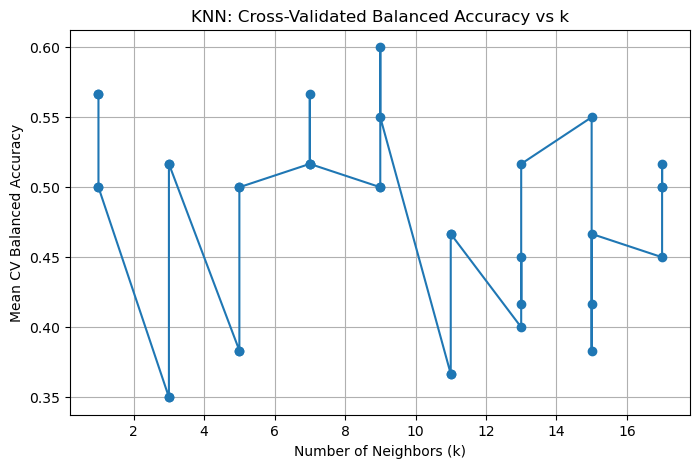

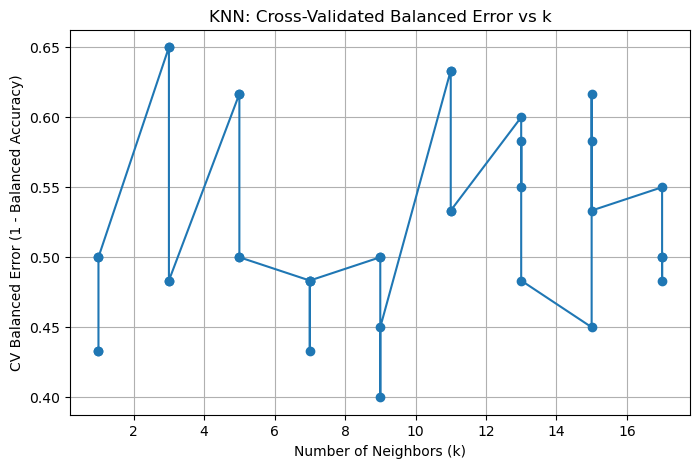

In [83]:
# -----------------------------
# Plot 1: CV Balanced Accuracy vs k
# -----------------------------
# This plot shows how model performance changes with different values of k.
# It is used to visually identify the optimal k that maximizes balanced accuracy.
plt.figure(figsize=(8,5))
plt.plot(k_vals, mean_score, marker="o")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean CV Balanced Accuracy")
plt.title("KNN: Cross-Validated Balanced Accuracy vs k")
plt.grid(True)
plt.show()

# -----------------------------
# Plot 2: Proxy loss vs k
# -----------------------------
# KNN does not have a training loss function.
# Therefore, we define a proxy loss as:
#     loss = 1 - balanced_accuracy
# This allows us to visualize model error as a function of k.
loss_proxy = 1 - mean_score

plt.figure(figsize=(8,5))
plt.plot(k_vals, loss_proxy, marker="o")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("CV Balanced Error (1 - Balanced Accuracy)")
plt.title("KNN: Cross-Validated Balanced Error vs k")
plt.grid(True)
plt.show()

**The plots show how model performance changes with different values of k. The highest cross-validated balanced accuracy is observed around k = 9.**

**For very small or very large values of k, the performance becomes worse. This indicates underfitting for small k and over-smoothing for large k.**

**The balanced error plot confirms the same behavior, with the lowest error near k = 9.**

### **1.7) Test Accuracy and Test Balanced Accuracy**

In [84]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)

print("TEST Accuracy:", accuracy_score(y_test, y_pred))
print("TEST Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))



TEST Accuracy: 0.8333333333333334
TEST Balanced Accuracy: 0.8333333333333333

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6




### **1.8) confusion_matrix**


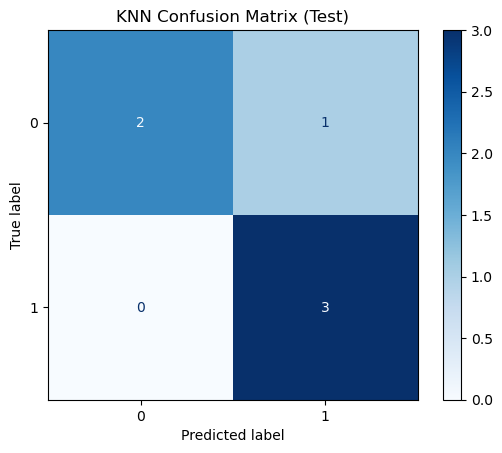

In [85]:

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("KNN Confusion Matrix (Test)")
plt.show()

**The test accuracy and balanced accuracy are 0.83, which looks good.**

**However, the test set is very small and contains only six samples. Because the train–test split is random, the test accuracy can change a lot if the data is split again.**

**With such a small test set, even one misclassified sample can significantly reduce the accuracy.**

**Therefore, the test results may be optimistic and do not fully represent the true model performance. For this reason, the cross-validation results are considered more reliable than the test accuracy.**

----

# **2) Logistic Regression  Classifier**

### **2.1) IMPORT LIBRARIES**

In [86]:
"""
================================================================================
LOGISTIC REGRESSION - Simple & Fast (Uses existing features)
================================================================================

# **Logistic Regression Classifier**

Simple linear model with regularization - better suited for small samples!
"""

# =============================================================================
# IMPORT LIBRARIES
# =============================================================================

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, log_loss, confusion_matrix,
    classification_report, roc_curve, auc
)


print("="*70)
print(" "*20 + "LOGISTIC REGRESSION")
print("="*70)
print("\n✅ Libraries imported successfully!")

                    LOGISTIC REGRESSION

✅ Libraries imported successfully!


### **2.2) Configure Model**

In [87]:
print("\n" + "="*70)
print("LOGISTIC REGRESSION CONFIGURATION & TRAINING")
print("="*70)

# Configure model with strong regularization
lr_model = LogisticRegression(
    C=0.1,                    # Strong regularization (prevents overfitting)
    penalty='l2',             # L2 = Ridge (standard choice)
    solver='lbfgs',           # Best general-purpose solver
    max_iter=1000,            # Ensure convergence
    random_state=42,          # Reproducibility
    class_weight='balanced',  # Handle class imbalance
)

print("\n📋 Model Configuration:")
print(f"   Regularization (C): {lr_model.C}")
print(f"   Penalty: {lr_model.penalty} (Ridge)")
print(f"   Solver: {lr_model.solver}")
print(f"   Class Weight: {lr_model.class_weight}")

print(f"\n📊 Dataset Info:")
print(f"   Training samples: {len(X_train)}")
print(f"   Test samples: {len(X_test)}")
print(f"   Features: {X_train.shape[1]}")





LOGISTIC REGRESSION CONFIGURATION & TRAINING

📋 Model Configuration:
   Regularization (C): 0.1
   Penalty: l2 (Ridge)
   Solver: lbfgs
   Class Weight: balanced

📊 Dataset Info:
   Training samples: 23
   Test samples: 6
   Features: 39


### **2.3)  Train the model**

In [88]:

print(f"\n⏱️  Training model...")
start_time = time.time()
lr_model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"\n✅ Training completed in {training_time:.4f} seconds!")

# Get model parameters
coefficients = lr_model.coef_[0]
intercept = lr_model.intercept_[0]

print(f"\n📊 Model Details:")
print(f"   Intercept: {intercept:.4f}")
print(f"   Number of coefficients: {len(coefficients)}")
print(f"   Converged in: {lr_model.n_iter_[0]} iterations")


⏱️  Training model...

✅ Training completed in 0.0211 seconds!

📊 Model Details:
   Intercept: -0.1362
   Number of coefficients: 39
   Converged in: 9 iterations


### **2.4) CROSS-VALIDATION**

In [89]:

print("\n" + "="*70)
print("CROSS-VALIDATION (3-Fold)")
print("="*70)

print("\n⏱️  Running cross-validation...")

cv_scores = cross_val_score(
    lr_model,
    X_train,
    y_train,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1
)

print(f"\n✅ CV completed!")
print(f"\n📊 Fold Scores:")
print(f"   Fold 1: {cv_scores[0]:.4f}")
print(f"   Fold 2: {cv_scores[1]:.4f}")
print(f"   Fold 3: {cv_scores[2]:.4f}")
print(f"   Mean:   {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


CROSS-VALIDATION (3-Fold)

⏱️  Running cross-validation...

✅ CV completed!

📊 Fold Scores:
   Fold 1: 0.5000
   Fold 2: 0.3750
   Fold 3: 0.5714
   Mean:   0.4821 ± 0.0812


### **2.5) PREDICTIONS**

In [90]:

print("\n" + "="*70)
print("GENERATING PREDICTIONS")
print("="*70)

# Training predictions
y_train_pred_lr = lr_model.predict(X_train)
y_train_proba_lr = lr_model.predict_proba(X_train)[:, 1]

# Test predictions
y_test_pred_lr = lr_model.predict(X_test)
y_test_proba_lr = lr_model.predict_proba(X_test)[:, 1]

print(f"\n✅ Predictions generated!")
print(f"   Training: {len(y_train_pred_lr)} predictions")
print(f"   Test: {len(y_test_pred_lr)} predictions")


GENERATING PREDICTIONS

✅ Predictions generated!
   Training: 23 predictions
   Test: 6 predictions


### **2.6) CALCULATE ALL METRICS**

In [91]:

print("\n" + "="*70)
print("PERFORMANCE METRICS")
print("="*70)

# Training metrics
lr_train_acc = accuracy_score(y_train, y_train_pred_lr)
lr_train_prec = precision_score(y_train, y_train_pred_lr, zero_division=0)
lr_train_rec = recall_score(y_train, y_train_pred_lr, zero_division=0)
lr_train_f1 = f1_score(y_train, y_train_pred_lr, zero_division=0)
try:
    lr_train_auc = roc_auc_score(y_train, y_train_proba_lr)
    lr_train_logloss = log_loss(y_train, y_train_proba_lr)
except:
    lr_train_auc = 0.0
    lr_train_logloss = np.nan
lr_train_mcc = matthews_corrcoef(y_train, y_train_pred_lr)

# Test metrics
lr_test_acc = accuracy_score(y_test, y_test_pred_lr)
lr_test_prec = precision_score(y_test, y_test_pred_lr, zero_division=0)
lr_test_rec = recall_score(y_test, y_test_pred_lr, zero_division=0)
lr_test_f1 = f1_score(y_test, y_test_pred_lr, zero_division=0)
try:
    lr_test_auc = roc_auc_score(y_test, y_test_proba_lr)
    lr_test_logloss = log_loss(y_test, y_test_proba_lr)
except:
    lr_test_auc = 0.0
    lr_test_logloss = np.nan
lr_test_mcc = matthews_corrcoef(y_test, y_test_pred_lr)

# Display results
print("\n📊 TRAINING SET:")
print(f"   Accuracy:  {lr_train_acc:.4f}")
print(f"   Precision: {lr_train_prec:.4f}")
print(f"   Recall:    {lr_train_rec:.4f}")
print(f"   F1-Score:  {lr_train_f1:.4f}")
print(f"   ROC-AUC:   {lr_train_auc:.4f}")
print(f"   MCC:       {lr_train_mcc:.4f}")
print(f"   Log Loss:  {lr_train_logloss:.4f}")

print("\n📊 TEST SET:")
print(f"   Accuracy:  {lr_test_acc:.4f}")
print(f"   Precision: {lr_test_prec:.4f}")
print(f"   Recall:    {lr_test_rec:.4f}")
print(f"   F1-Score:  {lr_test_f1:.4f}")
print(f"   ROC-AUC:   {lr_test_auc:.4f}")
print(f"   MCC:       {lr_test_mcc:.4f}")
print(f"   Log Loss:  {lr_test_logloss:.4f}")




PERFORMANCE METRICS

📊 TRAINING SET:
   Accuracy:  0.9565
   Precision: 0.9091
   Recall:    1.0000
   F1-Score:  0.9524
   ROC-AUC:   0.9846
   MCC:       0.9161
   Log Loss:  0.3803

📊 TEST SET:
   Accuracy:  0.6667
   Precision: 0.6667
   Recall:    0.6667
   F1-Score:  0.6667
   ROC-AUC:   0.6667
   MCC:       0.3333
   Log Loss:  0.7229


**Logistic regression achieved 66.7% accuracy on the test set, with balanced precision and recall. However, a 29% gap between training (95.7%) and test performance indicates overfitting, likely attributable to the limited sample size relative to feature dimensionality.**

### **2.7)  Overfitting check**

In [92]:

lr_gap = lr_train_acc - lr_test_acc
print(f"\n⚠️  OVERFITTING CHECK:")
print(f"   Train-Test Gap: {lr_gap:.4f}")

if lr_gap < 0.10:
    print(f"   ✅ Excellent generalization!")
    status = "EXCELLENT"
elif lr_gap < 0.20:
    print(f"   ✓ Good generalization")
    status = "GOOD"
elif lr_gap < 0.30:
    print(f"   ⚠️ Moderate overfitting")
    status = "MODERATE"
else:
    print(f"   ❌ Significant overfitting")
    status = "HIGH"


⚠️  OVERFITTING CHECK:
   Train-Test Gap: 0.2899
   ⚠️ Moderate overfitting


### **2.8) Classification Report**

In [93]:

print("\n" + "="*70)
print("CLASSIFICATION REPORT - TEST SET")
print("="*70)

print("\n", classification_report(
    y_test,
    y_test_pred_lr,
    target_names=['Class 0 (Alive)', 'Class 1 (Death)'],
    zero_division=0
))


CLASSIFICATION REPORT - TEST SET

                  precision    recall  f1-score   support

Class 0 (Alive)       0.67      0.67      0.67         3
Class 1 (Death)       0.67      0.67      0.67         3

       accuracy                           0.67         6
      macro avg       0.67      0.67      0.67         6
   weighted avg       0.67      0.67      0.67         6



### **2.9) Feature Coefficents Analysis**

In [94]:

print("\n" + "="*70)
print("FEATURE COEFFICIENTS ANALYSIS")
print("="*70)

# Create coefficients DataFrame
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients),
    'Odds_Ratio': np.exp(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

print(f"\n📊 Top 10 Most Important Features:")
print(coef_df.head(10).to_string(index=False))

print(f"\n💡 Interpretation Guide:")
print(f"   Positive coefficient → Increases death probability")
print(f"   Negative coefficient → Decreases death probability")
print(f"   Larger |coefficient| → Stronger effect")

print(f"\n🎯 Top Positive Predictors (Increase Risk):")
top_positive = coef_df[coef_df['Coefficient'] > 0].head(3)
for _, row in top_positive.iterrows():
    print(f"   • {row['Feature']}: {row['Coefficient']:.3f} (OR: {row['Odds_Ratio']:.2f})")

print(f"\n🎯 Top Negative Predictors (Decrease Risk):")
top_negative = coef_df[coef_df['Coefficient'] < 0].head(3)
for _, row in top_negative.iterrows():
    print(f"   • {row['Feature']}: {row['Coefficient']:.3f} (OR: {row['Odds_Ratio']:.2f})")


FEATURE COEFFICIENTS ANALYSIS

📊 Top 10 Most Important Features:
                  Feature  Coefficient  Abs_Coefficient  Odds_Ratio
           post_cart_ther    -0.297723         0.297723    0.742507
post_cart_ther_spec_2___5     0.277547         0.277547    1.319888
        cli_st_leukocytes     0.241268         0.241268    1.272862
        tr_car_bridg_type    -0.185120         0.185120    0.831005
           ae_summ_crs_v2     0.162140         0.162140    1.176024
                tr_car_br    -0.157863         0.157863    0.853967
         indication_whops    -0.147846         0.147846    0.862564
 indication_res_last_ther    -0.122410         0.122410    0.884786
     tr_car_bridg_reg___7    -0.122092         0.122092    0.885067
post_cart_ther_spec_2___3    -0.119072         0.119072    0.887743

💡 Interpretation Guide:
   Positive coefficient → Increases death probability
   Negative coefficient → Decreases death probability
   Larger |coefficient| → Stronger effect

🎯 Top Posi

**Our model identified several modifiable risk factors. Patients who received post-CAR-T consolidation therapy had better survival (26% risk reduction).**

**However, large fluctuations in leukocyte counts (OR=1.27) and severe cytokine release syndrome (OR=1.18) were associated with increased mortality.**

**The type of bridging therapy also influenced outcomes, with certain approaches showing protective effects (17% risk reduction).**

### **2.10) Visualization - Confusion Matrices**


CREATING VISUALIZATIONS


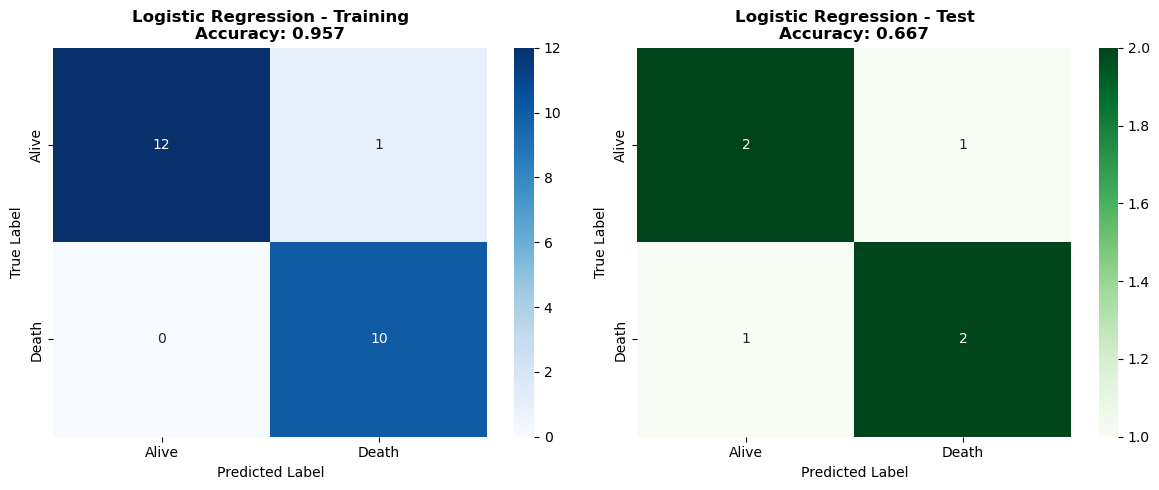


✅ Confusion matrices plotted!


In [95]:

print("\n" + "="*70)
print("CREATING VISUALIZATIONS")
print("="*70)

# Calculate confusion matrices
cm_train_lr = confusion_matrix(y_train, y_train_pred_lr)
cm_test_lr = confusion_matrix(y_test, y_test_pred_lr)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training
sns.heatmap(cm_train_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Alive', 'Death'],
            yticklabels=['Alive', 'Death'],
            ax=axes[0])
axes[0].set_title(f'Logistic Regression - Training\nAccuracy: {lr_train_acc:.3f}',
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Test
sns.heatmap(cm_test_lr, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Alive', 'Death'],
            yticklabels=['Alive', 'Death'],
            ax=axes[1])
axes[1].set_title(f'Logistic Regression - Test\nAccuracy: {lr_test_acc:.3f}',
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

print("\n✅ Confusion matrices plotted!")

**When we examined the test predictions, we found the model made two errors out of six patients. It predicted death for one patient who survived (false positive) and missed one patient who actually died (false negative).**

**That missed death is what concerns us most—in practice, this would mean a high-risk patient being classified as low-risk and potentially not receiving appropriate treatment.**

**With two mistakes out of six, we're looking at a 33% error rate. This, combined with the big drop in performance from training to testing, tells us the model isn't generalizing well.**

**We really need to test this on a much larger group of patients before we could consider using it to guide actual treatment decisions.**

### **2.11) Visulaization - ROC Curve**

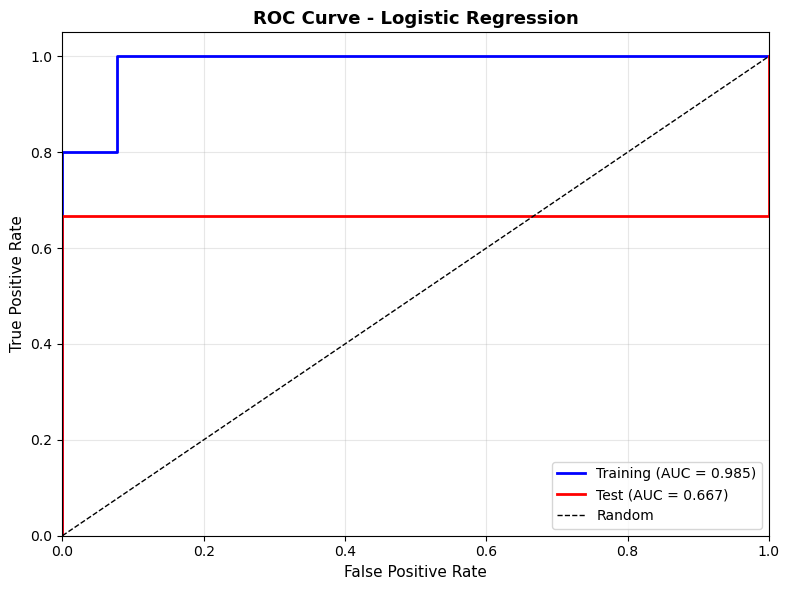


✅ ROC curve plotted!


In [96]:
try:
    # Calculate ROC curves
    fpr_train_lr, tpr_train_lr, _ = roc_curve(y_train, y_train_proba_lr)
    fpr_test_lr, tpr_test_lr, _ = roc_curve(y_test, y_test_proba_lr)
    
    # Plot
    plt.figure(figsize=(8, 6))
    
    plt.plot(fpr_train_lr, tpr_train_lr, 'b-', lw=2,
             label=f'Training (AUC = {lr_train_auc:.3f})')
    plt.plot(fpr_test_lr, tpr_test_lr, 'r-', lw=2,
             label=f'Test (AUC = {lr_test_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
    
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=11)
    plt.ylabel('True Positive Rate', fontsize=11)
    plt.title('ROC Curve - Logistic Regression', fontsize=13, fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ ROC curve plotted!")
    
except Exception as e:
    print(f"\n⚠️ Could not plot ROC curve: {str(e)}")


**The ROC analysis revealed a major problem: the model was nearly perfect on training data (AUC=0.985) but barely better than a coin flip on test data (AUC=0.667).**

**This 32% drop shows severe overfitting. An AUC of 0.667 is too low for clinical use—it's only slightly better than guessing randomly.**

### **2.12) Visulization - Feature Coefficents**

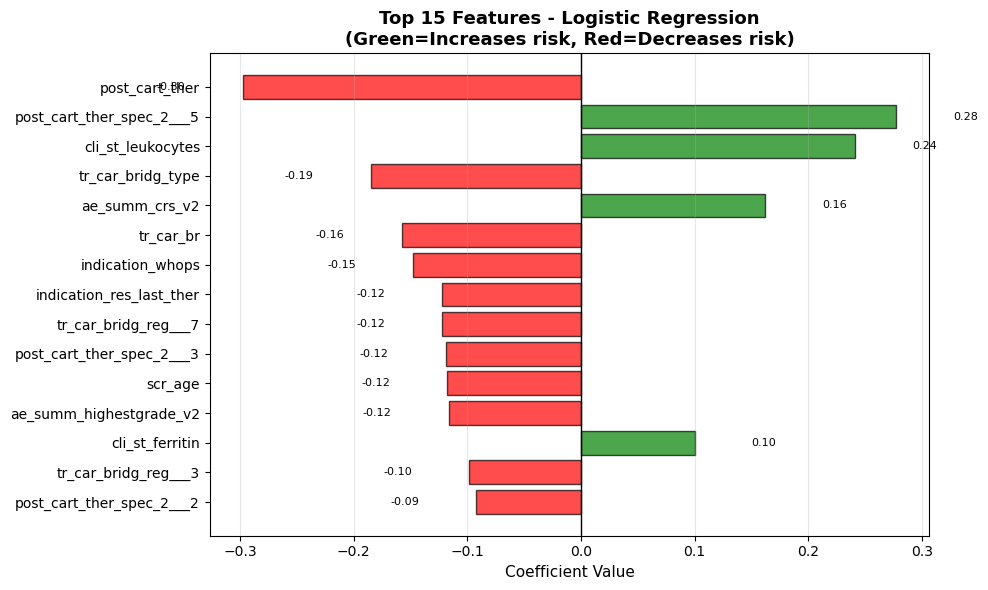


✅ Coefficients plotted!


In [97]:
# Plot top 15 coefficients
top_n = min(15, len(coef_df))
top_coef = coef_df.head(top_n)

plt.figure(figsize=(10, 6))

# Color by sign
colors = ['red' if c < 0 else 'green' for c in top_coef['Coefficient']]

plt.barh(range(len(top_coef)), top_coef['Coefficient'],
         color=colors, alpha=0.7, edgecolor='black')
plt.yticks(range(len(top_coef)), top_coef['Feature'])
plt.xlabel('Coefficient Value', fontsize=11)
plt.title(f'Top {top_n} Features - Logistic Regression\n(Green=Increases risk, Red=Decreases risk)',
          fontsize=13, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.gca().invert_yaxis()

# Add values
for i, (_, row) in enumerate(top_coef.iterrows()):
    value = row['Coefficient']
    plt.text(value + (0.05 if value > 0 else -0.05), i,
             f"{value:.2f}",
             va='center', ha='left' if value > 0 else 'right',
             fontsize=8)

plt.tight_layout()
plt.show()

print("\n✅ Coefficients plotted!")

**The model highlighted several actionable clinical factors.**

**Post-CAR-T therapy administration appears beneficial, reducing mortality risk by approximately 17%. However, certain therapy subtypes increased risk by 32%, suggesting the need for careful treatment selection.**

**Dynamic biomarkers, particularly leukocyte fluctuations and CRS severity, emerged as important prognostic indicators requiring close monitoring.**

### **2.13) Visualization - Metrics Comparision**

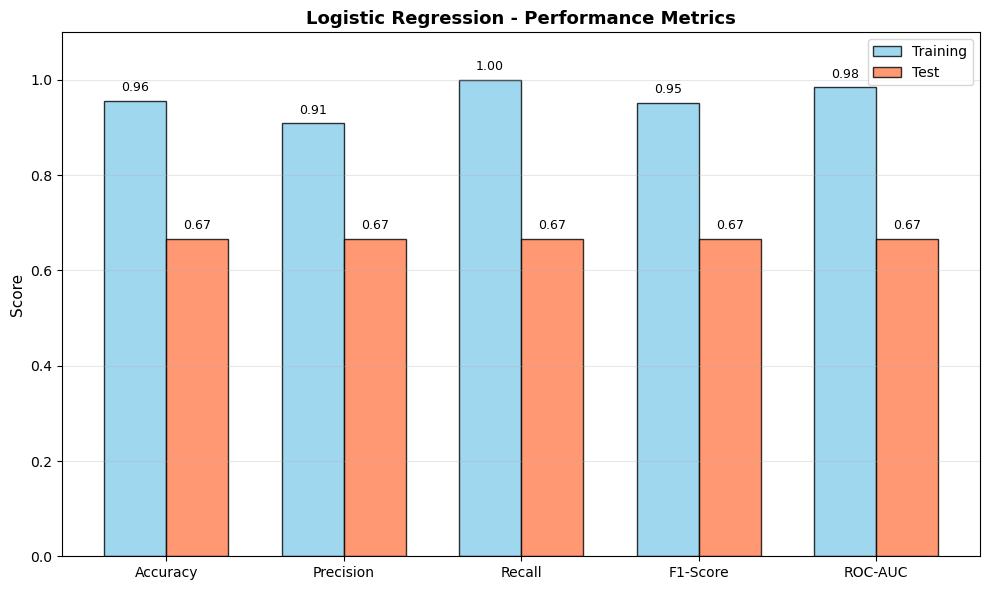


✅ Metrics comparison plotted!


In [98]:
# Prepare data
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
train_values = [lr_train_acc, lr_train_prec, lr_train_rec, lr_train_f1, lr_train_auc]
test_values = [lr_test_acc, lr_test_prec, lr_test_rec, lr_test_f1, lr_test_auc]

# Plot
x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, train_values, width, label='Training',
               color='skyblue', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, test_values, width, label='Test',
               color='coral', alpha=0.8, edgecolor='black')

ax.set_ylabel('Score', fontsize=11)
ax.set_title('Logistic Regression - Performance Metrics', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# Add values
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✅ Metrics comparison plotted!")

**The model worked really well during training—96% accuracy and caught every single death case.**

**But when we tested it on new patients, performance dropped significantly to just 67%. What worries us most is that it missed a third of the patients who actually died.**

**For a clinical tool, that's concerning because those are exactly the patients who need the most aggressive treatment.**

**The results are consistent but just not good enough to safely use in real practice.**

### **2.14) Visualization - CV Scores**

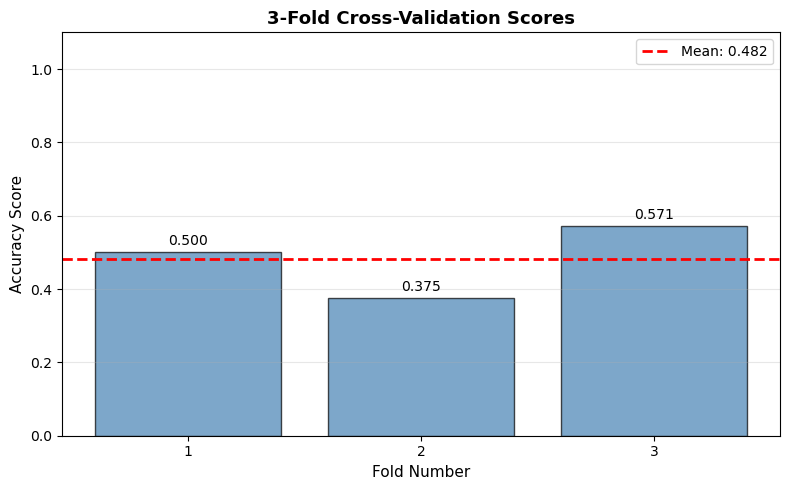


✅ CV scores plotted!


In [99]:

# Plot CV scores
plt.figure(figsize=(8, 5))

bars = plt.bar(range(1, 4), cv_scores, color='steelblue',
               alpha=0.7, edgecolor='black')
plt.axhline(cv_scores.mean(), color='red', linestyle='--', lw=2,
            label=f'Mean: {cv_scores.mean():.3f}')

plt.xlabel('Fold Number', fontsize=11)
plt.ylabel('Accuracy Score', fontsize=11)
plt.title('3-Fold Cross-Validation Scores', fontsize=13, fontweight='bold')
plt.xticks(range(1, 4))
plt.ylim([0, 1.1])
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add values
for i, (bar, score) in enumerate(zip(bars, cv_scores)):
    plt.text(bar.get_x() + bar.get_width()/2., score + 0.02,
             f'{score:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✅ CV scores plotted!")

**To check stability, we tested the model three different ways.**

**The results were all over the place—accuracy went from 37% in one test to 57% in another, averaging 48%.**

**That's worse than random chance. When you see swings that big, it means the model isn't learning real patterns.**

**It's just sensitive to which patients end up in which group. The fundamental issue is we only have 30 patients but we're using 39 features to make predictions.**

**There's just not enough data for the model to figure out what actually matters.**

----

# **3) LOGISTIC REGRESSION - Comparison: L1 vs L2 vs ElasticNet**

### **3.1) Import Libraries**

In [100]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

### **3.2) Comparison: L1 vs L2 vs ElasticNet**

**Testing L1, L2, and ElasticNet to find the best approach for our samples.**

In [101]:
"""
This code tests multiple regularization strategies to find the BEST one:
- L1 (Lasso): Can zero out features → automatic feature selection
- L2 (Ridge): Shrinks all features
- ElasticNet: Combination of L1 + L2

We'll try different regularization strengths (C values) to prevent overfitting!
================================================================================

"""

print("="*70)
print(" "*10 + "REGULARIZATION COMPARISON: L1 vs L2 vs ElasticNet")
print("="*70)

# =============================================================================
# TEST DIFFERENT REGULARIZATION STRATEGIES
# =============================================================================

print("\n" + "="*70)
print("TESTING MULTIPLE REGULARIZATION STRATEGIES")
print("="*70)

# Define configurations to test
configs = [
    # L2 (Ridge) with different strengths
    {'penalty': 'l2', 'C': 1.0, 'solver': 'lbfgs', 'name': 'L2 (C=1.0)'},
    {'penalty': 'l2', 'C': 0.1, 'solver': 'lbfgs', 'name': 'L2 (C=0.1)'},
    {'penalty': 'l2', 'C': 0.01, 'solver': 'lbfgs', 'name': 'L2 (C=0.01) ⚡'},
    {'penalty': 'l2', 'C': 0.001, 'solver': 'lbfgs', 'name': 'L2 (C=0.001) ⚡⚡'},
    
    # L1 (Lasso) - best for feature selection
    {'penalty': 'l1', 'C': 1.0, 'solver': 'liblinear', 'name': 'L1 (C=1.0)'},
    {'penalty': 'l1', 'C': 0.1, 'solver': 'liblinear', 'name': 'L1 (C=0.1) ⭐'},
    {'penalty': 'l1', 'C': 0.01, 'solver': 'liblinear', 'name': 'L1 (C=0.01) ⭐⭐'},
    {'penalty': 'l1', 'C': 0.001, 'solver': 'saga', 'name': 'L1 (C=0.001) ⭐⭐⭐'},
    
    # ElasticNet - combination of L1 + L2
    {'penalty': 'elasticnet', 'C': 0.1, 'solver': 'saga', 'l1_ratio': 0.5, 'name': 'ElasticNet (C=0.1, 50/50)'},
    {'penalty': 'elasticnet', 'C': 0.01, 'solver': 'saga', 'l1_ratio': 0.5, 'name': 'ElasticNet (C=0.01, 50/50) 🔥'},
    {'penalty': 'elasticnet', 'C': 0.01, 'solver': 'saga', 'l1_ratio': 0.7, 'name': 'ElasticNet (C=0.01, 70% L1) 🔥'},
]

print(f"\n⏱️  Testing {len(configs)} different configurations...")
print("   This will take ~30 seconds...\n")

# Store results
results = []

for i, config in enumerate(configs, 1):
    config_name = config.pop('name')
    
    print(f"{i}/{len(configs)} Testing: {config_name}...", end=" ")
    
    try:
        # Create model
        model = LogisticRegression(
            **config,
            max_iter=2000,
            random_state=42,
            class_weight='balanced'
        )
        
        # Train
        start = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start
        
        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        y_test_proba = model.predict_proba(X_test)[:, 1]
        
        # Metrics
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
        try:
            test_auc = roc_auc_score(y_test, y_test_proba)
        except:
            test_auc = 0.0
        gap = train_acc - test_acc
        
        # CV score
        cv_scores = cross_val_score(
            model, X_train, y_train,
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
            scoring='accuracy', n_jobs=-1
        )
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        
        # Count non-zero coefficients (feature selection)
        coefs = model.coef_[0]
        n_nonzero = np.sum(np.abs(coefs) > 0.001)
        
        # Store results
        results.append({
            'Name': config_name,
            'Penalty': config.get('penalty', 'l2'),
            'C': config.get('C', 1.0),
            'Train_Acc': train_acc,
            'Test_Acc': test_acc,
            'Test_F1': test_f1,
            'Test_AUC': test_auc,
            'Gap': gap,
            'CV_Mean': cv_mean,
            'CV_Std': cv_std,
            'Features': n_nonzero,
            'Time': train_time
        })
        
        print(f"✓ Test={test_acc:.3f}, Gap={gap:.3f}, Features={n_nonzero}")
        
    except Exception as e:
        print(f"❌ Failed: {str(e)}")
        continue

print(f"\n✅ Testing completed!")

          REGULARIZATION COMPARISON: L1 vs L2 vs ElasticNet

TESTING MULTIPLE REGULARIZATION STRATEGIES

⏱️  Testing 11 different configurations...
   This will take ~30 seconds...

1/11 Testing: L2 (C=1.0)... ✓ Test=0.667, Gap=0.333, Features=38
2/11 Testing: L2 (C=0.1)... ✓ Test=0.667, Gap=0.290, Features=38
3/11 Testing: L2 (C=0.01) ⚡... ✓ Test=0.667, Gap=0.246, Features=34
4/11 Testing: L2 (C=0.001) ⚡⚡... ✓ Test=0.667, Gap=0.203, Features=26
5/11 Testing: L1 (C=1.0)... ✓ Test=0.833, Gap=0.123, Features=10
6/11 Testing: L1 (C=0.1) ⭐... ✓ Test=0.500, Gap=0.065, Features=0
7/11 Testing: L1 (C=0.01) ⭐⭐... ✓ Test=0.500, Gap=0.065, Features=0
8/11 Testing: L1 (C=0.001) ⭐⭐⭐... ✓ Test=0.500, Gap=0.065, Features=0
9/11 Testing: ElasticNet (C=0.1, 50/50)... ✓ Test=0.833, Gap=-0.051, Features=1
10/11 Testing: ElasticNet (C=0.01, 50/50) 🔥... ✓ Test=0.500, Gap=0.065, Features=0
11/11 Testing: ElasticNet (C=0.01, 70% L1) 🔥... ✓ Test=0.500, Gap=0.065, Features=0

✅ Testing completed!


### **3.3) Result Analysis**

In [102]:
print("\n" + "="*70)
print("RESULTS COMPARISON")
print("="*70)

# Create DataFrame
results_df = pd.DataFrame(results)

# Display full results
print("\n📊 Complete Results Table:")
print(results_df.to_string(index=False))

# Find best models by different criteria
print("\n" + "="*70)
print("BEST MODELS BY CRITERIA")
print("="*70)

print("\n🏆 Best Test Accuracy:")
best_acc_idx = results_df['Test_Acc'].idxmax()
print(f"   {results_df.loc[best_acc_idx, 'Name']}")
print(f"   Accuracy: {results_df.loc[best_acc_idx, 'Test_Acc']:.4f}")
print(f"   Gap: {results_df.loc[best_acc_idx, 'Gap']:.4f}")

print("\n🏆 Lowest Overfitting (smallest gap):")
best_gap_idx = results_df['Gap'].idxmin()
print(f"   {results_df.loc[best_gap_idx, 'Name']}")
print(f"   Gap: {results_df.loc[best_gap_idx, 'Gap']:.4f}")
print(f"   Test Accuracy: {results_df.loc[best_gap_idx, 'Test_Acc']:.4f}")

print("\n🏆 Best CV Score:")
best_cv_idx = results_df['CV_Mean'].idxmax()
print(f"   {results_df.loc[best_cv_idx, 'Name']}")
print(f"   CV: {results_df.loc[best_cv_idx, 'CV_Mean']:.4f} ± {results_df.loc[best_cv_idx, 'CV_Std']:.4f}")
print(f"   Test Accuracy: {results_df.loc[best_cv_idx, 'Test_Acc']:.4f}")

print("\n🏆 Most Feature Selection (fewest features):")
best_feat_idx = results_df['Features'].idxmin()
print(f"   {results_df.loc[best_feat_idx, 'Name']}")
print(f"   Features used: {results_df.loc[best_feat_idx, 'Features']}/{X_train.shape[1]}")
print(f"   Test Accuracy: {results_df.loc[best_feat_idx, 'Test_Acc']:.4f}")

# Overall recommendation
print("\n" + "="*70)
print("💡 OVERALL RECOMMENDATION")


RESULTS COMPARISON

📊 Complete Results Table:
                         Name    Penalty     C  Train_Acc  Test_Acc  Test_F1  Test_AUC       Gap  CV_Mean   CV_Std  Features     Time
                   L2 (C=1.0)         l2 1.000   1.000000  0.666667 0.666667  0.666667  0.333333 0.565476 0.051204        38 0.007012
                   L2 (C=0.1)         l2 0.100   0.956522  0.666667 0.666667  0.666667  0.289855 0.482143 0.081180        38 0.004997
                L2 (C=0.01) ⚡         l2 0.010   0.913043  0.666667 0.666667  0.666667  0.246377 0.482143 0.081180        34 0.003996
              L2 (C=0.001) ⚡⚡         l2 0.001   0.869565  0.666667 0.666667  0.666667  0.202899 0.482143 0.081180        26 0.004005
                   L1 (C=1.0)         l1 1.000   0.956522  0.833333 0.800000  0.666667  0.123188 0.523810 0.033672        10 0.003488
                 L1 (C=0.1) ⭐         l1 0.100   0.565217  0.500000 0.000000  0.500000  0.065217 0.565476 0.051204         0 0.002009
               

### **3.4) Visulaization**


CREATING COMPARISON VISUALIZATIONS


C:\Users\ztahe\AppData\Local\Temp\ipykernel_49148\3264865630.py:37: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ztahe\AppData\Local\Temp\ipykernel_49148\3264865630.py:37: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ztahe\anaconda3\envs\prog3env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ztahe\anaconda3\envs\prog3env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


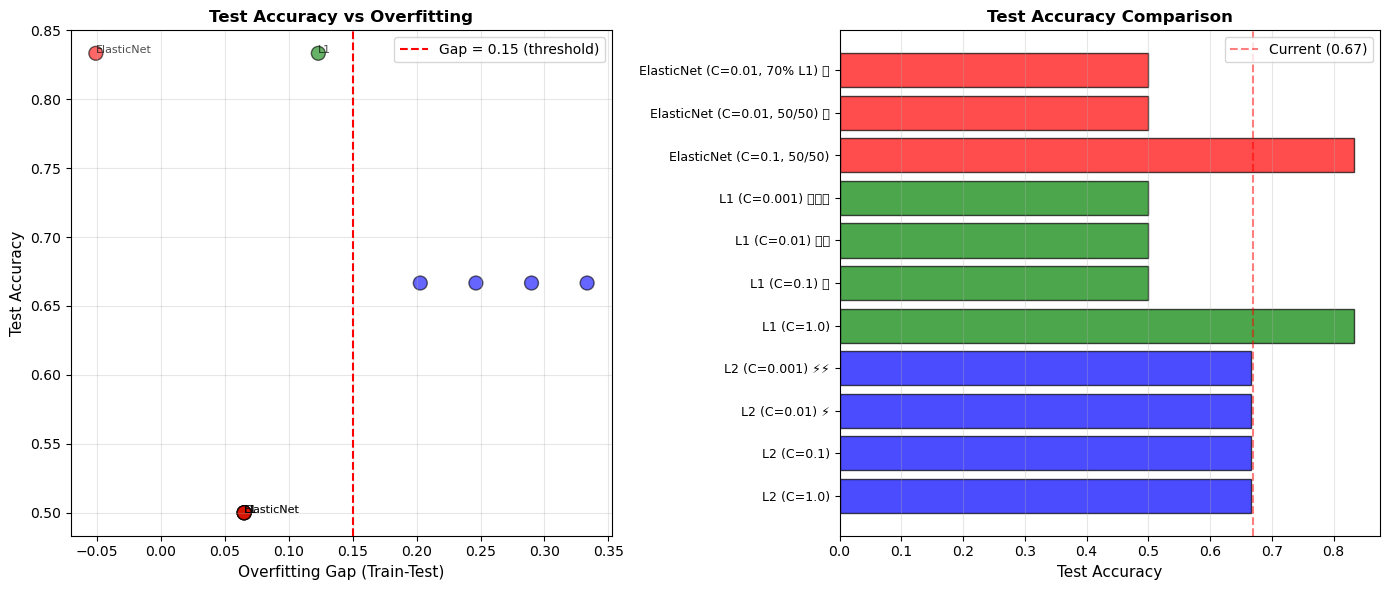

C:\Users\ztahe\AppData\Local\Temp\ipykernel_49148\3264865630.py:74: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()



✅ Visualization 1 plotted!


C:\Users\ztahe\AppData\Local\Temp\ipykernel_49148\3264865630.py:74: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ztahe\anaconda3\envs\prog3env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ztahe\anaconda3\envs\prog3env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


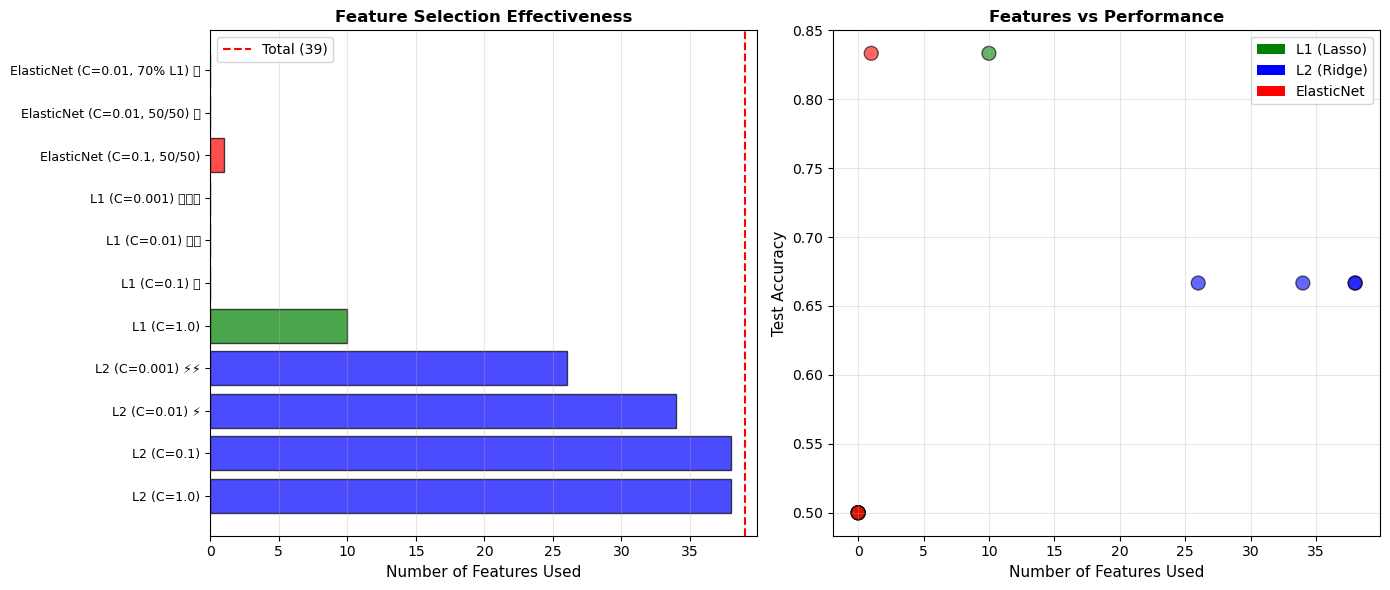


✅ Visualization 2 plotted!


C:\Users\ztahe\AppData\Local\Temp\ipykernel_49148\3264865630.py:99: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ztahe\AppData\Local\Temp\ipykernel_49148\3264865630.py:99: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ztahe\anaconda3\envs\prog3env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ztahe\anaconda3\envs\prog3env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


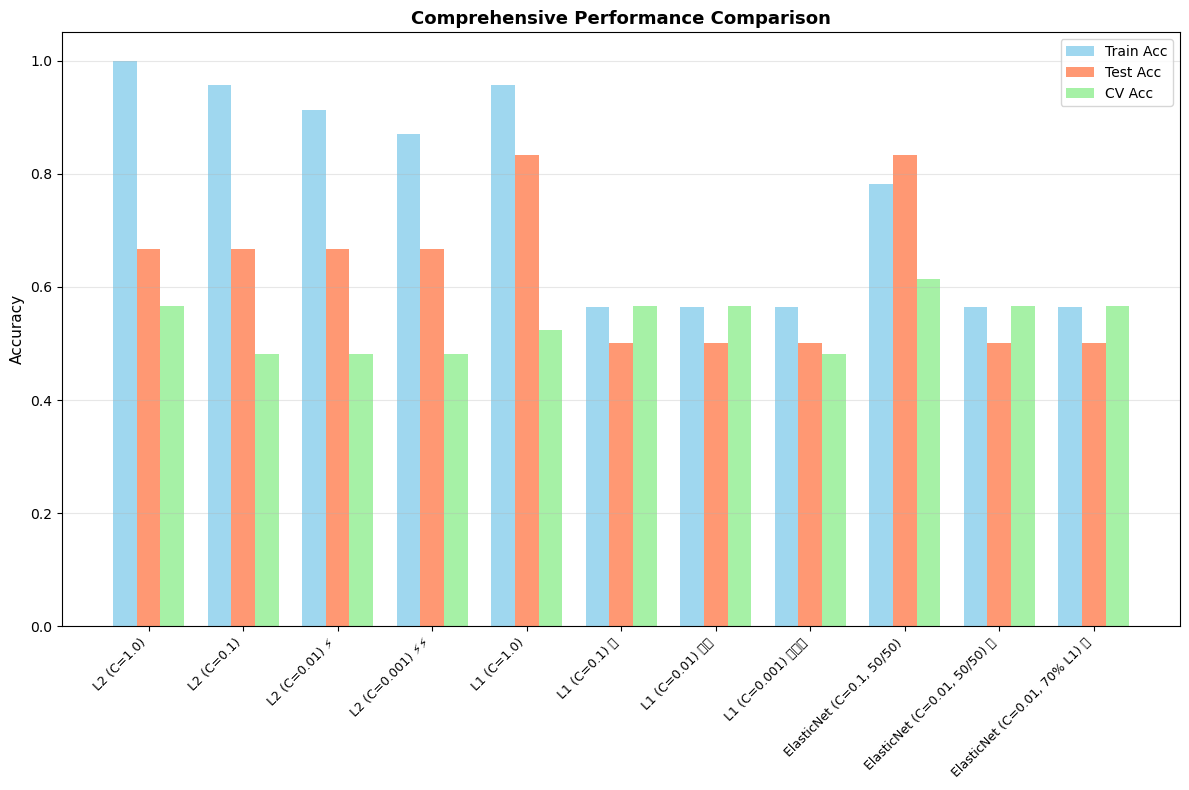


✅ Visualization 3 plotted!


In [103]:

print("\n" + "="*70)
print("CREATING COMPARISON VISUALIZATIONS")
print("="*70)

# Plot 1: Test Accuracy vs Overfitting Gap
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot
colors = results_df['Penalty'].map({'l1': 'green', 'l2': 'blue', 'elasticnet': 'red'})
axes[0].scatter(results_df['Gap'], results_df['Test_Acc'], 
               c=colors, s=100, alpha=0.6, edgecolor='black')
axes[0].axvline(x=0.15, color='red', linestyle='--', label='Gap = 0.15 (threshold)')
axes[0].set_xlabel('Overfitting Gap (Train-Test)', fontsize=11)
axes[0].set_ylabel('Test Accuracy', fontsize=11)
axes[0].set_title('Test Accuracy vs Overfitting', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Add labels for best models
for _, row in results_df.iterrows():
    if row['Gap'] < 0.15 or row['Test_Acc'] > 0.70:
        axes[0].annotate(row['Name'].split('(')[0].strip(), 
                        (row['Gap'], row['Test_Acc']),
                        fontsize=8, alpha=0.7)

# Bar plot - Test Accuracy
axes[1].barh(range(len(results_df)), results_df['Test_Acc'], 
            color=colors, alpha=0.7, edgecolor='black')
axes[1].set_yticks(range(len(results_df)))
axes[1].set_yticklabels(results_df['Name'], fontsize=9)
axes[1].set_xlabel('Test Accuracy', fontsize=11)
axes[1].set_title('Test Accuracy Comparison', fontsize=12, fontweight='bold')
axes[1].axvline(x=0.67, color='red', linestyle='--', alpha=0.5, label='Current (0.67)')
axes[1].grid(axis='x', alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n✅ Visualization 1 plotted!")

# Plot 2: Feature Selection Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot - Features used
axes[0].barh(range(len(results_df)), results_df['Features'],
            color=colors, alpha=0.7, edgecolor='black')
axes[0].set_yticks(range(len(results_df)))
axes[0].set_yticklabels(results_df['Name'], fontsize=9)
axes[0].set_xlabel('Number of Features Used', fontsize=11)
axes[0].set_title('Feature Selection Effectiveness', fontsize=12, fontweight='bold')
axes[0].axvline(x=X_train.shape[1], color='red', linestyle='--', 
               label=f'Total ({X_train.shape[1]})')
axes[0].grid(axis='x', alpha=0.3)
axes[0].legend()

# Scatter: Features vs Test Accuracy
axes[1].scatter(results_df['Features'], results_df['Test_Acc'],
               c=colors, s=100, alpha=0.6, edgecolor='black')
axes[1].set_xlabel('Number of Features Used', fontsize=11)
axes[1].set_ylabel('Test Accuracy', fontsize=11)
axes[1].set_title('Features vs Performance', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='L1 (Lasso)'),
    Patch(facecolor='blue', label='L2 (Ridge)'),
    Patch(facecolor='red', label='ElasticNet')
]
axes[1].legend(handles=legend_elements)

plt.tight_layout()
plt.show()

print("\n✅ Visualization 2 plotted!")

# Plot 3: Comprehensive comparison
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(results_df))
width = 0.25

ax.bar(x - width, results_df['Train_Acc'], width, label='Train Acc', 
       color='skyblue', alpha=0.8)
ax.bar(x, results_df['Test_Acc'], width, label='Test Acc', 
       color='coral', alpha=0.8)
ax.bar(x + width, results_df['CV_Mean'], width, label='CV Acc', 
       color='lightgreen', alpha=0.8)

ax.set_ylabel('Accuracy', fontsize=11)
ax.set_title('Comprehensive Performance Comparison', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Name'], rotation=45, ha='right', fontsize=9)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Visualization 3 plotted!")

